<a href="https://colab.research.google.com/github/lautarodc/machine_learning_II/blob/master/AM_II_Heart_Desease_Lautaro_Delgado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagnóstico de Enfermedades Cardíacas

---

El siguiente dataset cuenta con un número de variables a considerar al momento de diagnosticar si un paciente tiene o no una enfermedad cardíaca. El trabajo se estructurará de la siguiente manera:


*   [Exploración de los datos (EDA)](#s1)
*   [Ingeniería de Features (Feature Engineering)](#s2)
*   [Análisis de Outliers](#s3)
*   [Generación de Modelos](#s4)
*   [Comparación de Modelos](#s5)

<a name="s1"></a>

---
## Exploración de Datos


Instalar e Importar las Librerías

In [26]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [27]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz 
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

np.random.seed(123) 

pd.options.mode.chained_assignment = None  

In [28]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier, LassoCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2, f_classif

### Cargar los Datos

Los datos provienen de un dataset de kaggle en formato csv, que se importaron a una base de datos que se creó de forma local. Los scripts para crear la base de datos, el schema y cargar los datos del csv se pueden en contrar en el siguiente [repositorio](https://github.com/lautarodc/machine_learning_II). Dado que Google Colab no permite la conexión con una base de datos local, se creó una [App](https://heart-diseases-app.herokuapp.com/) en Heroku, se le agregó una instancia de PostgreSQL y se cargaron los datos del mísmo modo que se realizó para el local.

In [29]:
import psycopg2 as ps

In [30]:
# Estos son las variables de entorno de la base de datos de Heroku. Se deberían colocar como variables de entorno, pero Colab no tiene soporte.
host_name = 'ec2-34-232-212-164.compute-1.amazonaws.com'
dbname = 'dbnvaabvjl8n8u'
port = '5432'
user_name = 'rxdznkjytthqev'
pwd = 'a78edc41c52206189cbb0e6949e20f808dd2bc83bcbe9b6acc3353b36b99c3fe'

try:
    conn = ps.connect(host=host_name,database=dbname,user=user_name,password=pwd,port=port)
except ps.OperationalError as e:
    raise e
else:
    print('Conexión Exitosa')

Conexión Exitosa


In [31]:
cur = conn.cursor()
# Ejecutamos una query que traiga directamente toda la tabla
val = cur.execute(""" 
            SELECT *  FROM heart; 
            """)
data = cur.fetchall()
colnames = [desc[0] for desc in cur.description] 
conn.commit()

# Creamos un dataframe con los datos obtenidos
data = pd.DataFrame(data)
data.columns = colnames

In [32]:
queries = {'balance_output': """ SELECT target, COUNT(*) FROM heart GROUP BY target; """, 
           'age_statistics': """ SELECT MIN(age), MAX(age) FROM heart; """,
           'thal_target': """ SELECT thal, target, COUNT(*) FROM heart GROUP BY thal, target; """,
           'sex_target': """ SELECT sex, target, COUNT(*) FROM heart GROUP BY sex, target; """,
           'sex_thal_target': """ SELECT sex, thal, target, COUNT(*) FROM heart GROUP BY sex,thal,target, cp HAVING cp='2'; """}

In [33]:
conn.commit()

In [34]:
for query in queries.keys():
  val = cur.execute(queries[query])
  query_output = cur.fetchall()
  conn.commit()
  print(f"{query}: {query_output}")

balance_output: [('1', 165), ('0', 138)]
age_statistics: [('29', '77')]
thal_target: [('0', '0', 1), ('1', '1', 6), ('1', '0', 12), ('2', '0', 36), ('2', '1', 130), ('3', '0', 89), ('3', '1', 28), ('0', '1', 1)]
sex_target: [('1', '0', 114), ('0', '0', 24), ('0', '1', 72), ('1', '1', 93)]
sex_thal_target: [('1', '1', '0', 2), ('1', '2', '1', 26), ('0', '2', '1', 31), ('1', '3', '1', 9), ('0', '0', '1', 1), ('1', '3', '0', 10), ('0', '3', '1', 2), ('1', '2', '0', 5), ('0', '3', '0', 1)]


In [35]:
# Cerramos la conexión
cur.close()

In [36]:
data = data.drop(columns='row_timestamp')
data = data.astype({"age": int, "sex": int, "cp":int, "trestbps":int, "chol":int, "fbs":int, "restecg":int, "thalach":int,
                    "exang":int, "oldpeak":float, "slope":int, "ca":int, "thal":int, "target":int})

### Descripción básica de Datos

In [37]:
# Observamos las primeras 15 entradas de datos
data.head(5)

age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0   0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]

In [38]:
# Observamos las principales características
data.describe()

age         sex          cp  ...          ca        thal      target
count  303.000000  303.000000  303.000000  ...  303.000000  303.000000  303.000000
mean    54.366337    0.683168    0.966997  ...    0.729373    2.313531    0.544554
std      9.082101    0.466011    1.032052  ...    1.022606    0.612277    0.498835
min     29.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%     47.500000    0.000000    0.000000  ...    0.000000    2.000000    0.000000
50%     55.000000    1.000000    1.000000  ...    0.000000    2.000000    1.000000
75%     61.000000    1.000000    2.000000  ...    1.000000    3.000000    1.000000
max     77.000000    1.000000    3.000000  ...    4.000000    3.000000    1.000000

[8 rows x 14 columns]

### Profiling

In [39]:
profiling = pandas_profiling.ProfileReport(data)
profiling.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Es un dataset bastante sencillo de entender, pero algunas columnas no son tan intuitivas como otras:

*  age: Edad de la persona en años
*  sex: Género (1 = masculino, 0 = femenino)
*  cp: Dolor de pecho experimentado (1: angina típica, 2: angina atípica, 3: dolor que no es angina, 4: asintomático)
*  trestbps: Presión sanguínea en estado de reposo (mm Hg al momento de ser ingresado en el hospital)
*  chol: Colesterol de la persona en mg/dl
*  fbs: Azucar en sangre en ayunas (> 120 mg/dl)
*  restecg: ECG en reposo (0 = normal, 1 = ST-T anormalidad de onda, 2 = hipertrofía posible de la ventrícula izquierda según criterio de Estes
*  thalach: Ritmo cardíaco máximo alcanzado
*  exang:  Angina inducida por ejercicio
*  oldpeak: depresión ST inducida por ejercicio relativa al reposo (relacionado con posiciones de la curva de ECG) [ver link](https://www.my-ekg.com/como-leer-ekg/segmento-st.html#:~:text=Depresi%C3%B3n%20del%20segmento%20ST%20en,arteria%20coronaria%20(ver%20SCASEST)). 
*  slope: la pendiente del pico del segmento ST (1: ascendente, 2: plana, 3: descendente)
*  ca: Número de válvulas principales activadas por fluoroscopía (0-3)
*  thal: Desorden sanguíneo de talasemia (3 = normal; 6 = defecto fijo; 7 = defecto reversible)
*  target: Enfermedad Cardíaca (0 = no, 1 = si)


### Renombrar Columnas

Algunas variables tienen nombres poco indicativos por lo que se procede a renombrarlas a modo de referenciarlas más fácilmente. Este procedimiento se basa en lo realizado en:

*   [What causes heart disease explaining the model](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model)
*   [Heart Diseases Analysis](https://www.kaggle.com/roshansharma/heart-diseases-analysis/comments/)



In [40]:
data.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [41]:
data['sex'][data['sex'] == 0] = 'female'
data['sex'][data['sex'] == 1] = 'male'

data['chest_pain_type'][data['chest_pain_type'] == 1] = 'typical angina'
data['chest_pain_type'][data['chest_pain_type'] == 2] = 'atypical angina'
data['chest_pain_type'][data['chest_pain_type'] == 3] = 'non-anginal pain'
data['chest_pain_type'][data['chest_pain_type'] == 4] = 'asymptomatic'

data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

data['rest_ecg'][data['rest_ecg'] == 0] = 'normal'
data['rest_ecg'][data['rest_ecg'] == 1] = 'ST-T wave abnormality'
data['rest_ecg'][data['rest_ecg'] == 2] = 'left ventricular hypertrophy'

data['exercise_induced_angina'][data['exercise_induced_angina'] == 0] = 'no'
data['exercise_induced_angina'][data['exercise_induced_angina'] == 1] = 'yes'

data['st_slope'][data['st_slope'] == 1] = 'upsloping'
data['st_slope'][data['st_slope'] == 2] = 'flat'
data['st_slope'][data['st_slope'] == 3] = 'downsloping'

data['thalassemia'][data['thalassemia'] == 1] = 'normal'
data['thalassemia'][data['thalassemia'] == 2] = 'fixed defect'
data['thalassemia'][data['thalassemia'] == 3] = 'reversable defect'

In [42]:
print("Valores Únicos por Columna:")
for col in data.columns:
    print(col," : ", data[col].unique().size)

Valores Únicos por Columna:
age  :  41
sex  :  2
chest_pain_type  :  4
resting_blood_pressure  :  49
cholesterol  :  152
fasting_blood_sugar  :  2
rest_ecg  :  3
max_heart_rate_achieved  :  91
exercise_induced_angina  :  2
st_depression  :  40
st_slope  :  3
num_major_vessels  :  5
thalassemia  :  4
target  :  2


<a name="s2"></a>
## Feature Engineering

En la presente sección se analizarán las distintas variables del dataset, se observará cuáles de ellas son más significativas respecto de la variable target u objetivo y finalmente se seleccionará un conjunto de ellas para el armado de modelos.

Se observan los tipos de datos de las variables

In [43]:
data.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

### Verificar Nulls

Se verifica si hay algún dato faltante y se analiza cómo reemplazarlo.

In [44]:
data.isnull().sum(axis = 0)

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
cholesterol                0
fasting_blood_sugar        0
rest_ecg                   0
max_heart_rate_achieved    0
exercise_induced_angina    0
st_depression              0
st_slope                   0
num_major_vessels          0
thalassemia                0
target                     0
dtype: int64

Por suerte el dataset no cuenta con valores faltantes por lo que no se debe pensar su tratamiento.

### Eliminar observaciones duplicadas

Del reporte de Pandas Profilling, se observa que uno de los registros se encuentra duplicado por lo que se procede a eliminarlo.

In [45]:
data = data.drop_duplicates()
data.shape

(302, 14)

### Verificar Balance de la Salida

Otro de los aspectos importantes a verificar es si el dataset se encuentra o no balanceado respecto de la variable objetivo. Caso contrario, se debe buscar una manera de balancear el mismo.

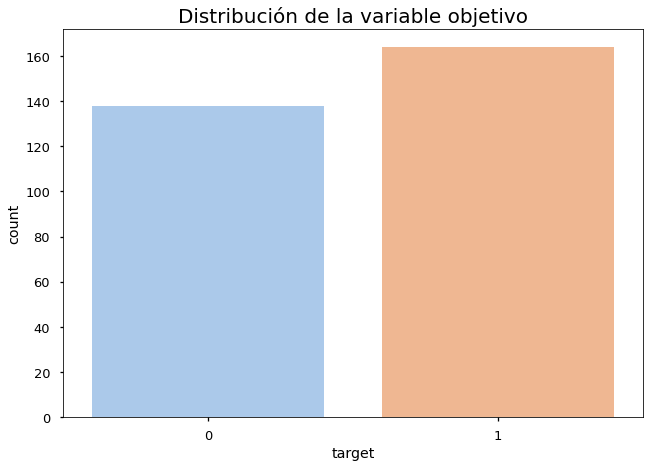

1    164
0    138
Name: target, dtype: int64


In [46]:
# Verificar si la variable target está o no balanceada
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 7)
plt.style.use('seaborn-talk')
sns.countplot(x = data['target'], palette = 'pastel')
plt.title('Distribución de la variable objetivo', fontsize = 20)
plt.show()

print(data.target.value_counts())

Como se observa, el dataset se encuentra bastante balanceado respecto de la variable a predecir, por lo que no es necesario ningún ajuste en particular.

### Variables Categóricas

Debemos analizar qué variables del dataset son categóricas y ver su tratamiento. Como se observó en los reportes anteriores, la cantidad de valores únicos de las variables categóricas no es alto, por lo que se puede realizar tranquilamente un one-hot encoding. 

In [47]:
categorical_columns = []
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append((col, data[col].unique().size))
categorical_columns

[('sex', 2),
 ('chest_pain_type', 4),
 ('fasting_blood_sugar', 2),
 ('rest_ecg', 3),
 ('exercise_induced_angina', 2),
 ('st_slope', 3),
 ('thalassemia', 4)]

#### One-hot encoding

La función get_dummies de pandas no es el mejor procedimiento para crear una codificación OHE, ya que no trata bien con nuevos casos en los datos de test. Por cuestiones de tiempo y simplicidad, se utiliza en este caso.

In [48]:
data = pd.get_dummies(data, drop_first=True)
data.head()

age  ...  thalassemia_reversable defect
0   63  ...                              0
1   37  ...                              0
2   41  ...                              0
3   56  ...                              0
4   57  ...                              0

[5 rows x 20 columns]

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      302 non-null    int64  
 1   resting_blood_pressure                   302 non-null    int64  
 2   cholesterol                              302 non-null    int64  
 3   max_heart_rate_achieved                  302 non-null    int64  
 4   st_depression                            302 non-null    float64
 5   num_major_vessels                        302 non-null    int64  
 6   target                                   302 non-null    int64  
 7   sex_male                                 302 non-null    uint8  
 8   chest_pain_type_atypical angina          302 non-null    uint8  
 9   chest_pain_type_non-anginal pain         302 non-null    uint8  
 10  chest_pain_type_typical angina           302 non-n

### Feature Selection

En el presente apartado, se explorarán distintas técnicas de selección de features al dataset para ver cuáles de pueden ser buenas candidatas para los modelos. 

El análisis está basado en:
* [Documentación de Scikit-Learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)
* [Feature Selection Techniques in Machine Learning with Python](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e#:~:text=Feature%20Selection%20is%20the%20process,learn%20based%20on%20irrelevant%20features.)
* [6 Ways for Feature Selection](https://www.kaggle.com/sz8416/6-ways-for-feature-selection)

Separamos el dataset en el set de features y la variable a predecir:

In [50]:
from sklearn.preprocessing import MinMaxScaler

y = data['target']
X = data.drop(columns = ['target'])
X_norm = MinMaxScaler().fit_transform(X)
print(y.shape)
print(X.shape)

(302,)
(302, 19)


#### Correlación de Pearson

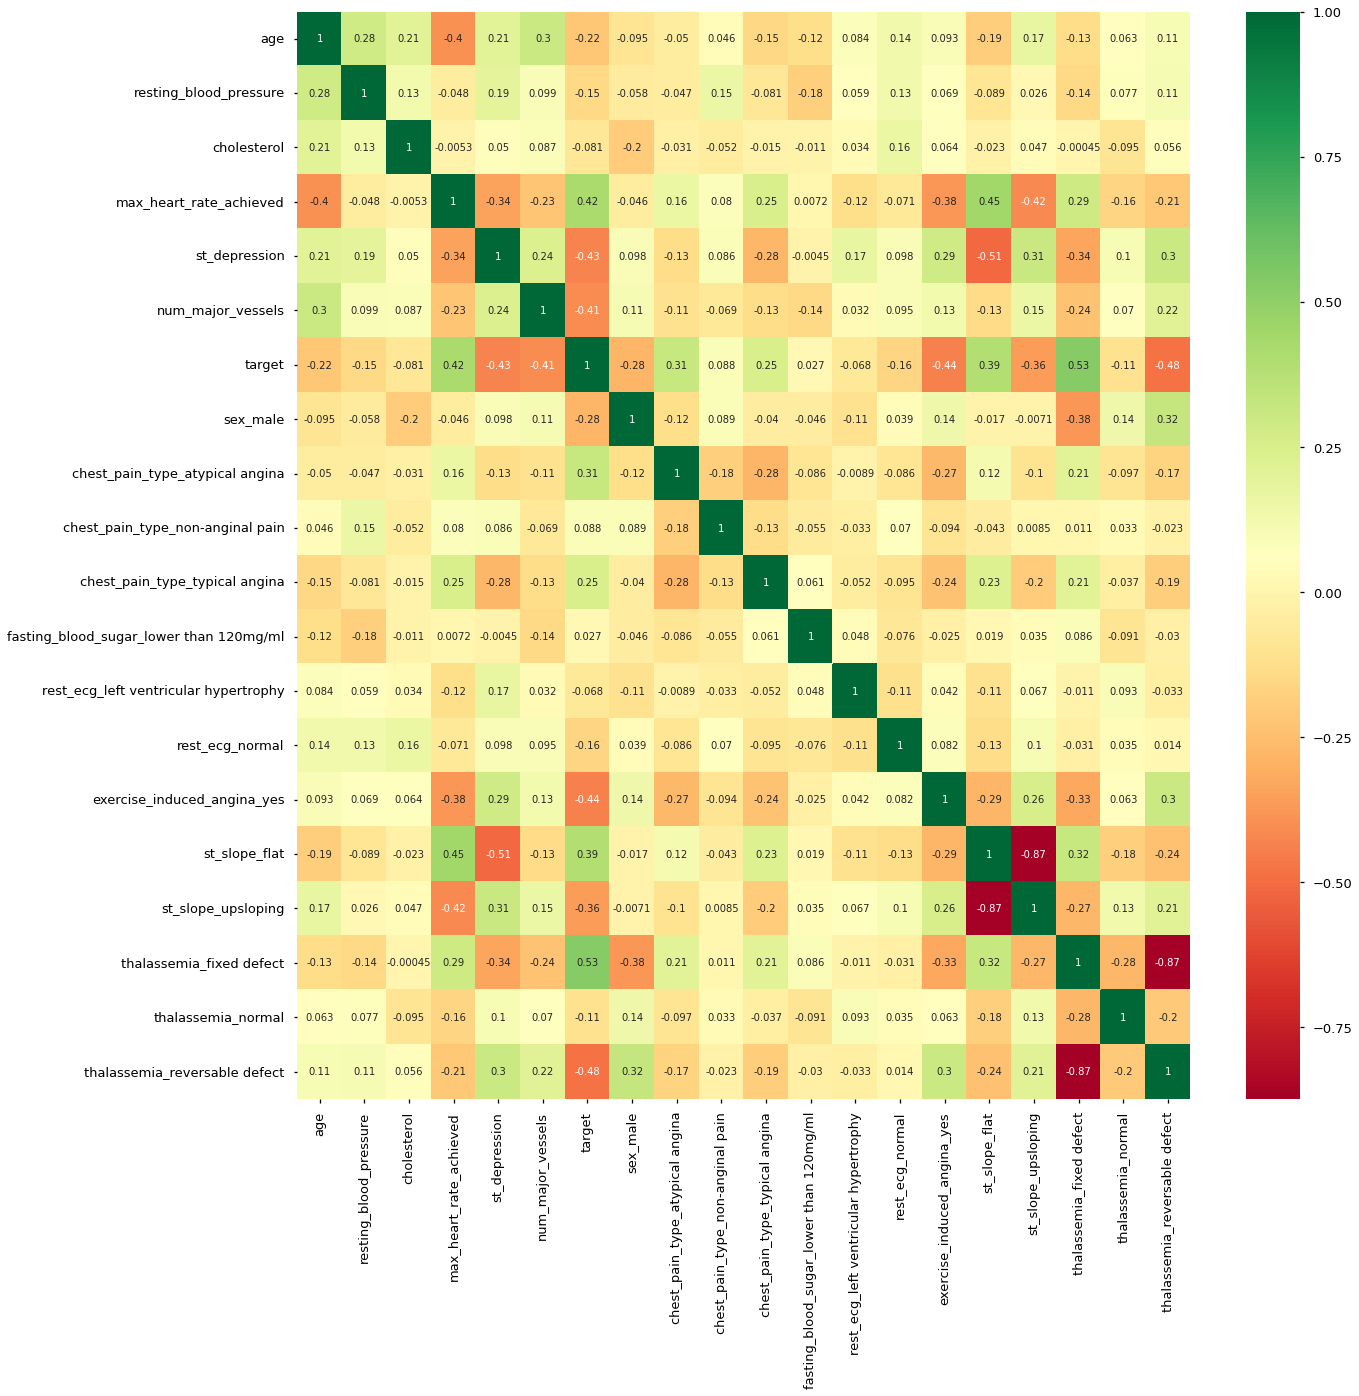

In [51]:
# Obtener la correlación entre cada una de las features (incluido el target)
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Del heatmap superior, se puede observar como la variable a predecir se encuentra bastante correlacionada en primer lugar, con las de thalassemia_fixed defect y thalassemia_reversable defect. 

Luego le siguen las de exercise_induced_angina, max_heart_rate_achieved, num_major_vessels, st_depression,st_slope_flat y st_slope_upsloping.

De todos modos, las variables que no se encuentren muy correlacionadas no se pueden descartar del análisis ya que puede que su relación con la salida no sea lineal o puede que una combinación de ellas tenga una alta correlación. 

Sí se podrían haber descartado features que entre si tengan una alta correlación, estableciendo algún umbral (generalmente 0.85-0.9), no siendo el caso de este dataset. 

#### Variance Threshold

Es un selector de features de scikit-learn que elimina de la selección, todas las features que tengan una varianza baja. Se establece un threshold para la varianza, pero por defecto elimina todas las features que tengan el mismo valor en todas las muestras. 

In [52]:
vt_best_features = []

In [53]:
selector = VarianceThreshold(threshold=0.2)
np.shape(selector.fit_transform(X_norm))
vt_best_features.append(list(np.array(X.columns)[selector.get_support(indices=False)]))
vt_best_features

[['sex_male',
  'chest_pain_type_atypical angina',
  'rest_ecg_normal',
  'exercise_induced_angina_yes',
  'st_slope_flat',
  'st_slope_upsloping',
  'thalassemia_fixed defect',
  'thalassemia_reversable defect']]

#### SelectFromModel

SelectFromModel es una utilidad de feature selection de scikit-learn que permite definir un estimador (cualquier modelo) preentrenado o no, un umbral para seleccionar las features, una norma (l1, etc) sobre la que se establece el umbral y un parámetro opcional de máxima cantidad de features. 

En función de los modelos seleccionados, se pueden obtener diferentes features de acuerdo al peso de su importancia. A continuación, se experimentará con algunos modelos. 

In [54]:
sfm_best_features = []

##### Linear SVC

El Linear Support Vector Classification es similar a un SVM con kernel lineal, pero con mayor libertad en la elección de parámetros. 

Se puede modificar la penalidad (l1 o l2), dual (tipo de problema de optimización, en este caso que hay mas datos que features se selecciona False) y C (parámetro de regularización) 

In [55]:
# Creamos el modelo LinearSVC con parámetros estándar y lo entrenamos sobre el conjunto de datos.

lsvc = LinearSVC(C=0.5, penalty="l2", dual=False).fit(X_norm, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_norm)
X_selected_df = pd.DataFrame(X_new, columns=[X.columns[i] for i in range(len(X.columns)) if model.get_support()[i]])
sfm_best_features.append(X_selected_df.columns.tolist())

##### LassoCV

Modelo lineal Lasso estándar

In [56]:
lasso = LassoCV(cv=3).fit(X_norm, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X_norm)
X_selected_df = pd.DataFrame(X_new, columns=[X.columns[i] for i in range(len(X.columns)) if model.get_support()[i]])
sfm_best_features.append(X_selected_df.columns.tolist())

Vemos si el método de SelectFromModel con ambos modelos da resultados parecidos y qué variables han detectado ambos modelos como importantes.

In [57]:
sfm_best_features

[['resting_blood_pressure',
  'cholesterol',
  'max_heart_rate_achieved',
  'st_depression',
  'num_major_vessels',
  'sex_male',
  'chest_pain_type_atypical angina',
  'chest_pain_type_non-anginal pain',
  'thalassemia_fixed defect'],
 ['age',
  'resting_blood_pressure',
  'cholesterol',
  'max_heart_rate_achieved',
  'st_depression',
  'num_major_vessels',
  'sex_male',
  'chest_pain_type_atypical angina',
  'chest_pain_type_non-anginal pain',
  'chest_pain_type_typical angina',
  'fasting_blood_sugar_lower than 120mg/ml',
  'rest_ecg_left ventricular hypertrophy',
  'rest_ecg_normal',
  'exercise_induced_angina_yes',
  'st_slope_flat',
  'st_slope_upsloping',
  'thalassemia_fixed defect',
  'thalassemia_normal',
  'thalassemia_reversable defect']]

In [58]:
# Ver qué features se encuentran en ambos modelos. 
main_cols_min = sfm_best_features[0]
for i in range(len(sfm_best_features)-1):
    main_cols_min = list(set(main_cols_min).intersection(set(sfm_best_features[i+1])))
main_cols_min

['cholesterol',
 'num_major_vessels',
 'thalassemia_fixed defect',
 'chest_pain_type_non-anginal pain',
 'st_depression',
 'max_heart_rate_achieved',
 'chest_pain_type_atypical angina',
 'resting_blood_pressure',
 'sex_male']

#### Selección Univariable - SelectKBest

Scikit-learn tiene una clase que puede ser utilizada con una variedad de test estadísticos para seleccionar una cantidad específica de features.

Se pueden ajustar los parámetros de score_func (el test a utilizar) y k (cantidad de clases)

##### Chi2
En este caso se va a utilizar el Chi2.

In [59]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X_norm, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
stat_test_features = []

# Visualizamos el score de cada feature en una columna 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
# Almacenamos las mejores 10 en función del score asignado
stat_test_features.append(featureScores.nlargest(10,'Score')['Feature'].tolist())
print(featureScores.nlargest(len(dfcolumns),'Score')) 

                                    Feature      Score
18            thalassemia_reversable defect  43.496322
13              exercise_induced_angina_yes  38.518849
16                 thalassemia_fixed defect  37.908888
14                            st_slope_flat  24.755178
7           chest_pain_type_atypical angina  21.255469
15                       st_slope_upsloping  21.025300
5                         num_major_vessels  17.755180
9            chest_pain_type_typical angina  15.455217
4                             st_depression  11.563352
6                                  sex_male   7.721690
12                          rest_ecg_normal   3.835152
17                       thalassemia_normal   3.190173
3                   max_heart_rate_achieved   2.705524
8          chest_pain_type_non-anginal pain   2.158544
11    rest_ecg_left ventricular hypertrophy   1.384279
0                                       age   0.990594
1                    resting_blood_pressure   0.498381
2         

##### Annova

In [60]:
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X_norm, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Visualizamos el score de cada feature en una columna 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
# Almacenamos las mejores 10 en función del score asignado
stat_test_features.append(featureScores.nlargest(10,'Score')['Feature'].tolist())
print(featureScores.nlargest(len(dfcolumns),'Score')) 

                                    Feature       Score
16                 thalassemia_fixed defect  114.769795
18            thalassemia_reversable defect   92.215953
13              exercise_induced_angina_yes   70.255191
4                             st_depression   67.721931
3                   max_heart_rate_achieved   64.237793
5                         num_major_vessels   60.262749
14                            st_slope_flat   54.508884
15                       st_slope_upsloping   44.742710
7           chest_pain_type_atypical angina   32.743618
6                                  sex_male   26.240952
9            chest_pain_type_typical angina   19.601215
0                                       age   15.474511
12                          rest_ecg_normal    7.611199
1                    resting_blood_pressure    6.558676
17                       thalassemia_normal    3.408185
8          chest_pain_type_non-anginal pain    2.339112
2                               cholesterol    2

#### Eliminación de Features Recursiva

La función de recursive feature elimination de scikit-learn, toma como parámetro un modelo o estimador, que naturalmente asigna pesos a las features de un determinado modo. La RFE va seleccionando recursivamente un conjunto de features cada vez más acotado, descartando primero aquellas features con menor score (coef_ o feature_importances_). Se repite el funcionamiento recursivamente hasta que se obtiene la cantidad de features deseada. 

*   [Documentación Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)
*   [Guía Scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html#rfe)




In [61]:
rfe_features = []

##### RFE Regresión Logística

In [62]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=2, verbose=2)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
rfe_features.append(rfe_feature)

Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
10 selected features


##### RFE Random Forest

In [63]:
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=200), n_features_to_select=10, step=2, verbose=2)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
rfe_features.append(rfe_feature)

Fitting estimator with 19 features.
Fitting estimator with 17 features.
Fitting estimator with 15 features.
Fitting estimator with 13 features.
Fitting estimator with 11 features.
10 selected features


Ver que features se encuentran en ambos casos:

In [64]:
# Ver qué features se encuentran en ambos modelos. 
main_cols_min = rfe_features[0]
for i in range(len(rfe_features)-1):
    main_cols_min = list(set(main_cols_min).intersection(set(rfe_features[i+1])))
main_cols_min

['thalassemia_reversable defect',
 'num_major_vessels',
 'st_depression',
 'max_heart_rate_achieved',
 'resting_blood_pressure']

#### Mejores Features

A partir de los análisis de feature selection realizados, se eligen las mejores features para utilizar en los modelos.

In [65]:
# Se colocan todas las features seleccionadas en cada uno de los métodos en la misma lista
best_features = []
best_features.append(vt_best_features[0])
best_features.append(sfm_best_features[0])
best_features.append(sfm_best_features[1])
best_features.append(stat_test_features[0])
best_features.append(stat_test_features[1])
best_features.append(rfe_features[0])
best_features.append(rfe_features[1])
# Verificamos que elementos se encuentran al menos una vez dentro de los seleccionados
main_cols_max = best_features[0]
for i in range(len(best_features)-1):
    main_cols_max = list(set(main_cols_max).union(set(best_features[i+1])))
print(main_cols_max)

main_cols_min = best_features[0]
for i in range(len(best_features)-1):
    main_cols_min = list(set(main_cols_min).intersection(set(best_features[i+1])))
print(main_cols_min)


['fasting_blood_sugar_lower than 120mg/ml', 'chest_pain_type_typical angina', 'thalassemia_fixed defect', 'chest_pain_type_atypical angina', 'st_slope_upsloping', 'st_depression', 'rest_ecg_normal', 'resting_blood_pressure', 'thalassemia_reversable defect', 'cholesterol', 'num_major_vessels', 'rest_ecg_left ventricular hypertrophy', 'chest_pain_type_non-anginal pain', 'thalassemia_normal', 'st_slope_flat', 'exercise_induced_angina_yes', 'max_heart_rate_achieved', 'age', 'sex_male']
[]


In [66]:
print(len(main_cols_max))
print(len(main_cols_min))

19
0


In [67]:
# Ordenar las features en función de la cantidad de veces que fueron seleccionadas por algún método
main_cols = []
main_cols_opt = {feature_name : 0 for feature_name in data.columns.tolist()}
for i in range(len(best_features)):
    for feature_name in best_features[i]:
        main_cols_opt[feature_name] += 1
df_main_cols_opt = pd.DataFrame.from_dict(main_cols_opt, orient='index', columns=['Num'])
df_main_cols_opt.sort_values(by=['Num'], ascending=False).head(19)

Num
thalassemia_reversable defect              6
thalassemia_fixed defect                   6
st_depression                              6
num_major_vessels                          6
sex_male                                   6
chest_pain_type_atypical angina            6
exercise_induced_angina_yes                5
max_heart_rate_achieved                    5
st_slope_upsloping                         5
st_slope_flat                              5
resting_blood_pressure                     4
chest_pain_type_typical angina             3
chest_pain_type_non-anginal pain           3
cholesterol                                3
rest_ecg_normal                            2
age                                        2
rest_ecg_left ventricular hypertrophy      1
fasting_blood_sugar_lower than 120mg/ml    1
thalassemia_normal                         1

A partir del cuadro superior, se decide tomar todas las features que al menos hayan sido seleccionadas por 3 métodos distintos. Sin embargo, se graficará la distribución de las features remanentes para taxativamente verificar si no tienen influencia en la variable de salida. Para graficar la distribución, se utilizará el método de kernel density estimation (KDE) visto en estadística. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

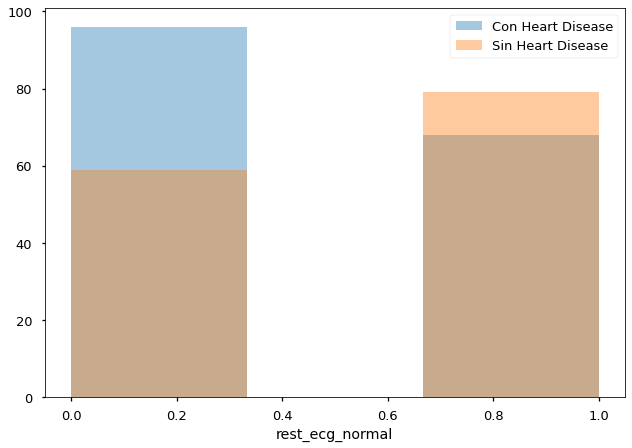

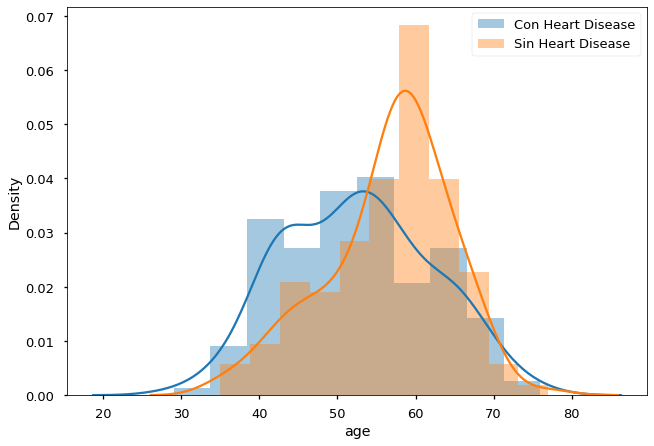

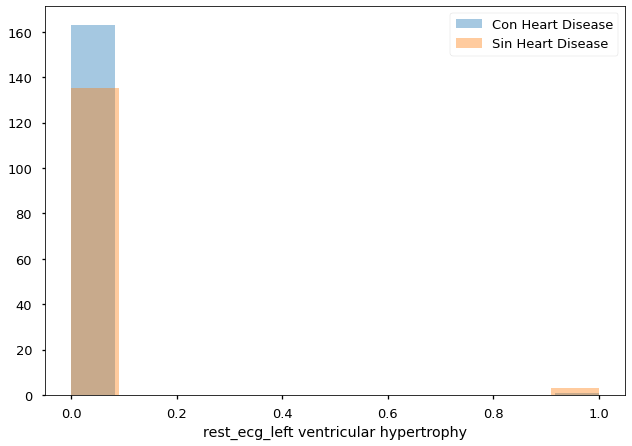

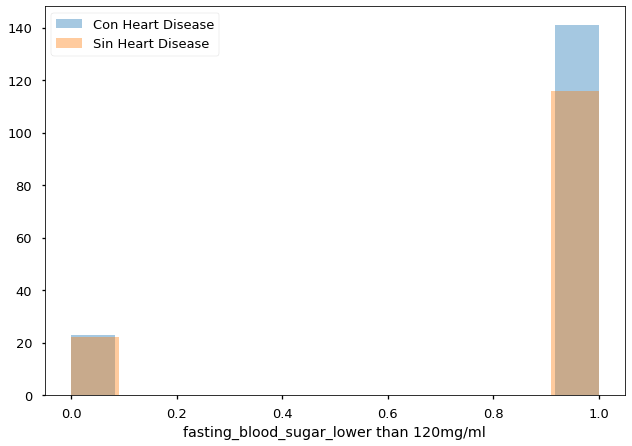

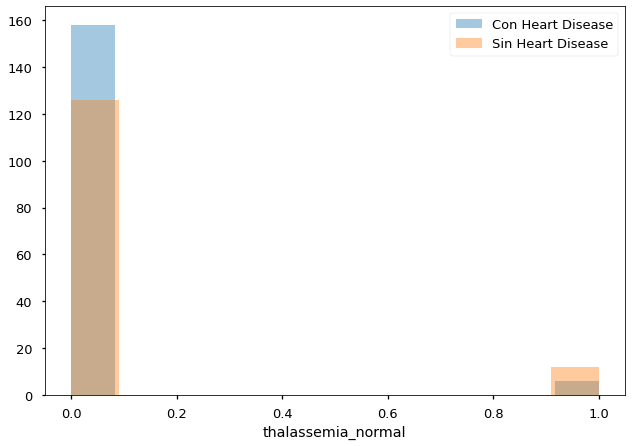

In [68]:
remain_columns = ['rest_ecg_normal', 'age', 'rest_ecg_left ventricular hypertrophy', 'fasting_blood_sugar_lower than 120mg/ml', 'thalassemia_normal']
pos = data[data['target'] == 1]
neg = data[data['target'] == 0]

for col in remain_columns :
    if col == 'age':
      kde_flag = True
    else:
      kde_flag = False
    plt.figure()
    sns.distplot(pos[col], label = 'Con Heart Disease', kde = kde_flag)
    sns.distplot(neg[col], label = 'Sin Heart Disease', kde = kde_flag)
    plt.legend()

Como se observa de las gráficas anteriores, no es posible a través de las distribuciones distinguir un patrón para cada feature que nos permita separar los casos positivos de los casos negativos.

<a name="s3"></a>


---

## Análisis de Outliers

Es importante al momento de analizar cualquier dataset, detectar cuáles son los valores que representan outliers dentro del mismo, ya que modifican la distribución de los datos ocasionando modelos incorrectos. Incluso pueden alterar las hipótesis de normalidad en la distribución, sobre la que se basan muchos de los modelos utilizados comunmente. 

Existen Outliers de una sola variable y multivariables y sus métodos de detección son distintos. Para este dataset, se realizarán los tests univariables sobre algunas columnas en particular. 

### Test de Hipótesis (Grubber)

Dado que el test de Grubber es univariable, lo ejecutaremos sobre las features que tengan mayor variabilidad o cantidad de valores únicos. Se dejan aquí nuevamente para mayor claridad. 

In [69]:
print("Valores Únicos por Columna:")
for col in X.columns:
    print(col," : ", X[col].unique().size)

Valores Únicos por Columna:
age  :  41
resting_blood_pressure  :  49
cholesterol  :  152
max_heart_rate_achieved  :  91
st_depression  :  40
num_major_vessels  :  5
sex_male  :  2
chest_pain_type_atypical angina  :  2
chest_pain_type_non-anginal pain  :  2
chest_pain_type_typical angina  :  2
fasting_blood_sugar_lower than 120mg/ml  :  2
rest_ecg_left ventricular hypertrophy  :  2
rest_ecg_normal  :  2
exercise_induced_angina_yes  :  2
st_slope_flat  :  2
st_slope_upsloping  :  2
thalassemia_fixed defect  :  2
thalassemia_normal  :  2
thalassemia_reversable defect  :  2


In [70]:
import scipy.stats as stats

grubbs_outliers = []

def grubbs_test(x, col):
    out = {}
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    out['feature'] = col
    out['g_calc'] = g_calculated
    out['g_critic'] = g_critical
    if g_critical > g_calculated:
      out['outliers'] = 0
    else:
      out['outliers'] = 1
    return out

for col in X.columns:
  if X[col].unique().size >= 40:
    out_col = grubbs_test(X[col], col)
    grubbs_outliers.append(out_col)
    print("Análisis de Grubb de Outliers para {} : {} ".format(col, out_col))


Análisis de Grubb de Outliers para age : {'feature': 'age', 'g_calc': 2.8141917242401897, 'g_critic': 3.7254308351110867, 'outliers': 0} 
Análisis de Grubb de Outliers para resting_blood_pressure : {'feature': 'resting_blood_pressure', 'g_calc': 3.9007763959763575, 'g_critic': 3.7254308351110867, 'outliers': 1} 
Análisis de Grubb de Outliers para cholesterol : {'feature': 'cholesterol', 'g_calc': 6.145034461975383, 'g_critic': 3.7254308351110867, 'outliers': 1} 
Análisis de Grubb de Outliers para max_heart_rate_achieved : {'feature': 'max_heart_rate_achieved', 'g_calc': 3.4361494418459433, 'g_critic': 3.7254308351110867, 'outliers': 0} 
Análisis de Grubb de Outliers para st_depression : {'feature': 'st_depression', 'g_calc': 4.4474602668325325, 'g_critic': 3.7254308351110867, 'outliers': 1} 


### Z-Score Robusto

De acuerdo con la teoría estadística, con el Z-Score se puede observar que tan lejos de la media se encuentra una observación. Es una convención que si una observación se encuentra alejada de la media 3 veces la desviación estándar, se puede considerar outlier. 

El problema de basar ese análisis en el Z-Score estándar es que la media y la desviación estándar se ven altamente afectadas por los outliers. Es por ello que se calcula en función de la mediana y la distancia de las observaciones a la misma. 


In [71]:
zscore_outliers = []

def ZRscore_outlier(x, col):
    out = {}
    points = []
    med = np.median(x)
    ma = stats.median_absolute_deviation(x)
    for i in x: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            points.append(i)
    out['feature'] = col
    out['points'] = points  
    return out

for col in X.columns:
  if X[col].unique().size >= 40:
    out_col = ZRscore_outlier(X[col], col)
    zscore_outliers.append(out_col)
    print("Análisis de Z-Score de Outliers para {} : {} ".format(col, out_col['points']))


Análisis de Z-Score de Outliers para age : [] 
Análisis de Z-Score de Outliers para resting_blood_pressure : [200] 
Análisis de Z-Score de Outliers para cholesterol : [564] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  import sys


Análisis de Z-Score de Outliers para max_heart_rate_achieved : [] 
Análisis de Z-Score de Outliers para st_depression : [6.2] 


### Método IQR

En este método se utiliza el rango intercuartil para detectar los outliers. El rango intercuartil (IQR) es aquel que se extiende desde el percentil 25 (Q1) hasta el percentil 75 (Q3). Cualquier valor que sea menor a Q1-1.5*IQR o mayor a Q3+1.5*IQR, es considerado un outlier. Pierde precisión si la distribución de los datos no es normal.

In [72]:
iqr_outliers = []

def iqr_outliers_det(x, col):
    out = {}
    points = []
    for i in x:
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        if i > Upper_tail or i < Lower_tail:
            points.append(i)
    out['feature'] = col
    out['points'] = points  
    return out       

for col in X.columns:
  if X[col].unique().size >= 40:
    out_col = iqr_outliers_det(X[col], col)
    iqr_outliers.append(out_col)
    print("Análisis de IQR de Outliers para {} : {} ".format(col, out_col['points']))

Análisis de IQR de Outliers para age : [] 
Análisis de IQR de Outliers para resting_blood_pressure : [172, 178, 180, 180, 200, 174, 192, 178, 180] 
Análisis de IQR de Outliers para cholesterol : [417, 564, 394, 407, 409] 
Análisis de IQR de Outliers para max_heart_rate_achieved : [71] 
Análisis de IQR de Outliers para st_depression : [4.2, 6.2, 5.6, 4.2, 4.4] 


### Winsorization

En este método, sin un valor se encuentra por encima del percentil 99 o por debajo del percentil 1, se considera un outlier.

In [73]:
winsor_outliers = []

def Winsorization_outliers(x, col):
    out = {}
    points = []
    for i in x:
        q1 = np.percentile(x , 1)
        q3 = np.percentile(x , 99)
        if i > q3 or i < q1:
            points.append(i)
    out['feature'] = col
    out['points'] = points  
    return out

for col in X.columns:
  if X[col].unique().size >= 40:
    out_col = Winsorization_outliers(X[col], col)
    winsor_outliers.append(out_col)
    print("Análisis de Winsorization de Outliers para {} : {} ".format(col, out_col['points']))

Análisis de Winsorization de Outliers para age : [34, 29, 34, 74, 76, 77] 
Análisis de Winsorization de Outliers para resting_blood_pressure : [94, 94, 200, 192] 
Análisis de Winsorization de Outliers para cholesterol : [417, 141, 564, 126, 407, 409, 131] 
Análisis de Winsorization de Outliers para max_heart_rate_achieved : [202, 194, 192, 88, 195, 95, 71, 90] 
Análisis de Winsorization de Outliers para st_depression : [6.2, 5.6, 4.4] 


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

Es un algoritmo de clustering similar a K-Means que junta en clusters los puntos del dataset e identifica los que no pertenecen a ninguno como outliers. A diferencia de k-means, no es necesario indicar la cantidad de cluster pero si un valor epsilon de distancia respecto de un centro de cluster y el mínimo número de muestras para formar uno. 

Mientras todos los análisis realizados anteriormenente fueron univariables, DBSCAN permite análisis multivariable. Se utilizarán aquí únicamente las variables continuas (para usar la distancia euclidiana) y se graficarán los clusters de a dos variables para su visualización. Se deben escalar o normalizar los datos para su aplicación. 

In [74]:
df_norm = pd.DataFrame(data = X_norm, columns = X.columns)
df_norm.head()

age  ...  thalassemia_reversable defect
0  0.708333  ...                            0.0
1  0.166667  ...                            0.0
2  0.250000  ...                            0.0
3  0.562500  ...                            0.0
4  0.583333  ...                            0.0

[5 rows x 19 columns]

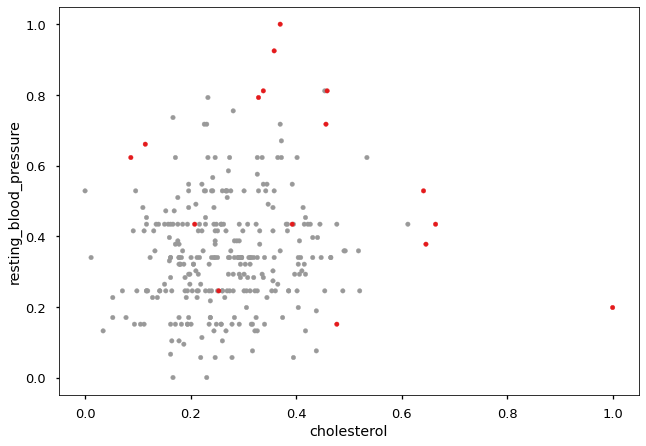

In [75]:
from sklearn.cluster import DBSCAN
from matplotlib import cm

dbscan_outliers = DBSCAN(
 eps = .2, 
 metric = "euclidean", 
 min_samples = 5,
 n_jobs = -1)

df_norm_cont = df_norm[['resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression']]

clusters = dbscan_outliers.fit_predict(df_norm_cont)

cmap = cm.get_cmap('Set1')
df_norm_cont.plot.scatter(x='cholesterol',y='resting_blood_pressure', c=clusters, cmap=cmap,
 colorbar = False)


### Isolation Forest

Es un algoritmo de la familia de los modelos con árboles donde se selecciona aleatoriamente una feature y un valor para la misma dentro de un determinado rango. Se va modificando el rango a medida que se procesan las observaciones y si se encuentra una observación donde ninguna otra muestra tiene valores dentro del rango de la misma, se considera aislada (outlier). El procedimiento es iterativo y se debe indicar la cantidad de veces a ejecutar esos pasos.

In [76]:
from sklearn.ensemble import IsolationForest

rs=np.random.RandomState(0)
clf = IsolationForest(max_samples=300, random_state=rs,  contamination=.01) 
clf.fit(df_norm_cont)
if_scores = clf.decision_function(df_norm_cont)
if_anomalies=clf.predict(df_norm_cont)
if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies=df_norm[if_anomalies==1];

Se realiza un histograma de los valores de if_scores donde un valor más bajo indica observaciones que sean más anómalas.

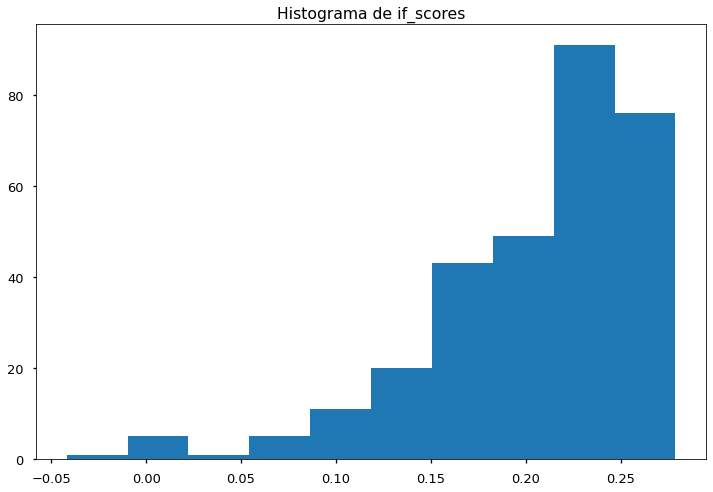

In [77]:
plt.figure(figsize=(12,8))
plt.hist(if_scores);
plt.title('Histograma de if_scores');

Text(0.5, 1.0, 'Isolation Forests - rbl vs. ch')

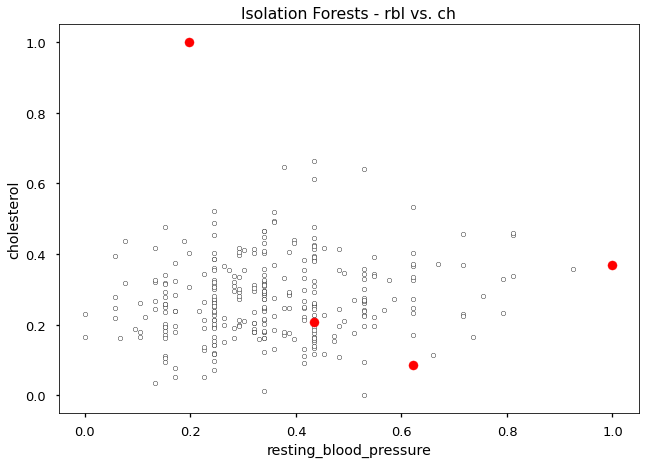

In [78]:
cmap=np.array(['white','red'])
plt.scatter(df_norm_cont['resting_blood_pressure'],df_norm_cont['cholesterol'],c='white',s=20,edgecolor='k')
plt.scatter(if_anomalies['resting_blood_pressure'],if_anomalies['cholesterol'],c='red')
plt.xlabel('resting_blood_pressure')
plt.ylabel('cholesterol')
plt.title('Isolation Forests - rbl vs. ch')

### Resumen y Tratamiento

A continuación, analizaremos cuáles valores han sido detectados como anómalos por varios de los métodos y en qué features. Para ello, utilizaremos boxplots que permiten observarlos más fácilmente.


* Análisis Univariable
  *   Test de Grubber: Outliers en resting_blood_pressure, cholesterol, st_depression 
  *   Z-Score Robusto: Outliers en resting_blood_pressure [200], cholesterol [564] y st_depression [6.2]
  *   IQR: Outliers en resting_blood_pressure [172, 178, 180, 180, 200, 174, 192, 178, 180], cholesterol [417, 564, 394, 407, 409], max_heart_rate_achieved [71], st_depression [4.2, 6.2, 5.6, 4.2, 4.4]
  * Winsorization: Outliers en age [34, 29, 34, 74, 76, 77], resting_blood_pressure [94, 94, 200, 192], cholesterol [417, 141, 564, 126, 407, 409, 131], max_heart_rate_achieved [202, 194, 192, 88, 195, 95, 71, 90], st_depression [6.2, 5.6, 4.4]

* Análisis Multivariable
  * DBSCAN
  



Previo al tratamiento de los outliers, realizaremos una copia del dataset para comparar la performance del modelo, con y sin las transformaciones.

In [79]:
X_outliers = X.copy()

In [80]:
idx = clusters == -1
idx = idx.nonzero()
X.iloc[idx[0]]

age  ...  thalassemia_reversable defect
28    65  ...                              0
85    67  ...                              1
101   59  ...                              1
195   59  ...                              1
203   68  ...                              1
204   62  ...                              1
220   63  ...                              1
221   55  ...                              1
223   56  ...                              1
246   56  ...                              1
248   54  ...                              1
250   51  ...                              1
266   55  ...                              0
272   67  ...                              0
288   57  ...                              1
297   59  ...                              0

[16 rows x 19 columns]

* Análisis Multivariable
  * Isolation Forest

In [81]:
X.iloc[if_anomalies.index]

age  ...  thalassemia_reversable defect
85    67  ...                              1
204   62  ...                              1
221   55  ...                              1
223   56  ...                              1

[4 rows x 19 columns]

Respecto del análisis multivariable se puede observar que las 4 muestras que Isolation Forest clasificó como outliers, se encuentran también en el análisis de DBSCAN. Por otro lado, en todos los métodos univariables se encontraron estos outliers: resting_blood_pressure [200], cholesterol [564] y st_depression [6.2]. Incluso el test de Grubber dio como resultado que esas tres features contenían outliers y esos valores se encuentran también identificados por DBSCAN e Isolation Forest, por lo que se procederá a tratarlos. 

Tanto IQR como Winsorization, encontraron un gran número de outliers que ni siquiera han sido identificados por DBSCAN, que detectó 16 muestras con outliers.

*   IQR: resting_blood_pressure [172, 174], cholesterol [394], st_depression [4.4]
*   Winsorization: age [34, 29, 34, 74, 76, 77], resting_blood_pressure [94, 94], cholesterol [141, 126, 131], max_heart_rate_achieved [202, 194, 192, 88, 95], [4.4]

Como se puede observar, Winsorization pareciera ser el método menos preciso al momento de encontrar outliers para este dataset, sobre todo teniendo en cuenta que ningún otro método detectó outliers en la variable age. 

A continuación, se realizará el tratamiento de las 4 muestras con outliers que detectó isolation forest que contempla lo identificado por otros métodos. A saber:

Index | Feature | Valor
--- | --- | ---
85 | cholesterol | 564
204 | st_depression| 6.2
221 | st_depression| 5.6
223 | resting_blood_pressure |200

Para procesar los outliers, se utiliza generalmente alguna de las siguientes técnicas:
* Borrar la muestra
* Transformar los valores (scaling, log, cube root normalization, Box-Cox)
* Imputación (media, mediana, cero)

En este caso, se realizará la imputación de los valores por su mediana ya que es una práctica común y efectiva. Para este conjunto de datos en particular no conviene eliminar las muestras ya que de por sí es un dataset reducido. 


En primer lugar, graficaremos los box-plots de las features con outliers previo al procesamiento para poder compararlos. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


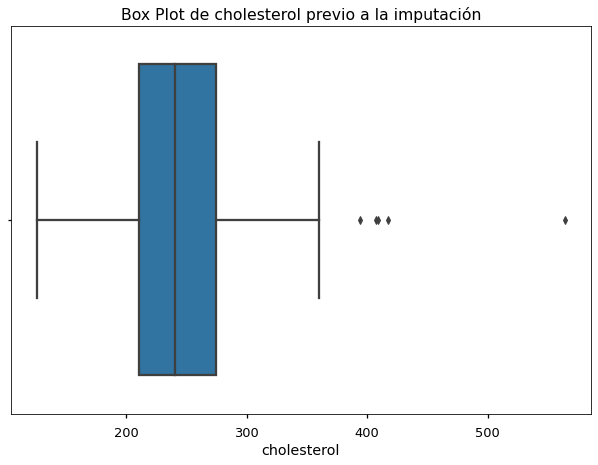

In [82]:
sns.boxplot(X['cholesterol'])
plt.title("Box Plot de cholesterol previo a la imputación")
plt.show()

In [83]:
# Reemplazamos el outlier por la mediana
X['cholesterol'].iloc[85] = np.median(X['cholesterol'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


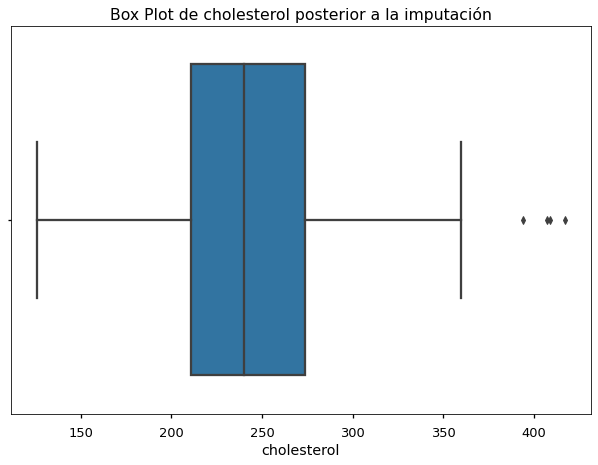

In [84]:
sns.boxplot(X['cholesterol'])
plt.title("Box Plot de cholesterol posterior a la imputación")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


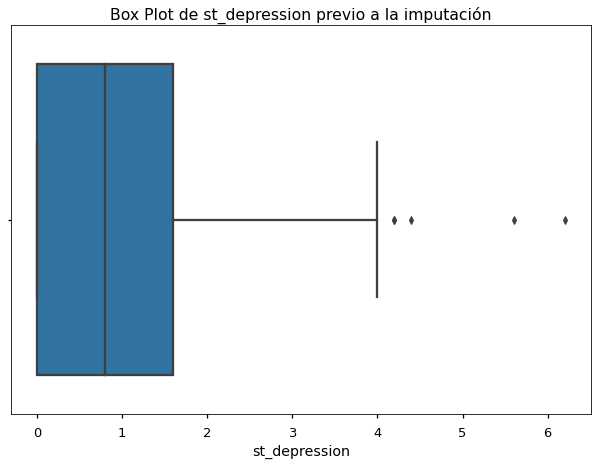

In [85]:
sns.boxplot(X['st_depression'])
plt.title("Box Plot de st_depression previo a la imputación")
plt.show()

In [86]:
# Reemplazamos el outlier por la mediana
X['st_depression'] = X['st_depression'].replace(6.2, np.median(X['st_depression']))
X['st_depression'] = X['st_depression'].replace(5.6, np.median(X['st_depression']))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


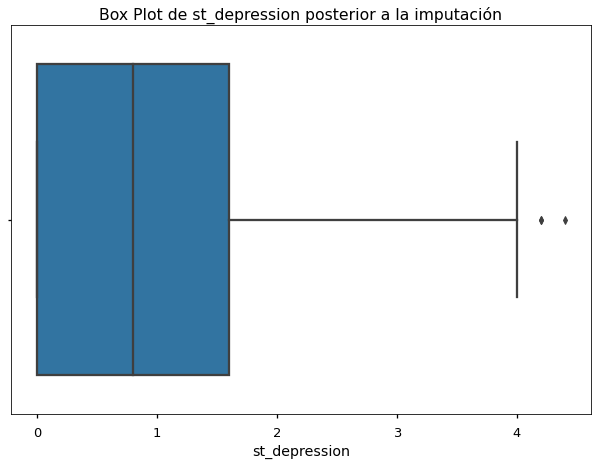

In [87]:

sns.boxplot(X['st_depression'])
plt.title("Box Plot de st_depression posterior a la imputación")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


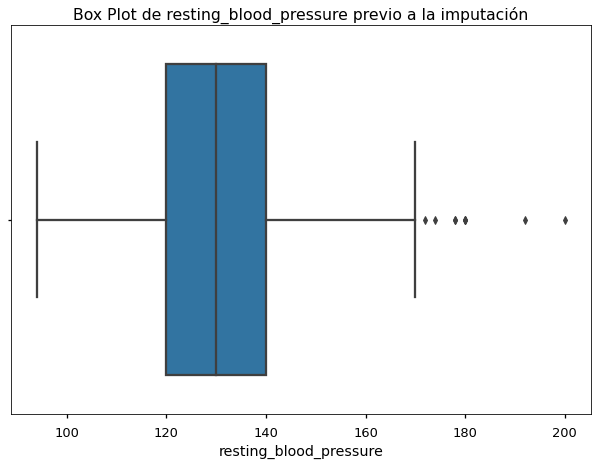

In [88]:
sns.boxplot(X['resting_blood_pressure'])
plt.title("Box Plot de resting_blood_pressure previo a la imputación")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


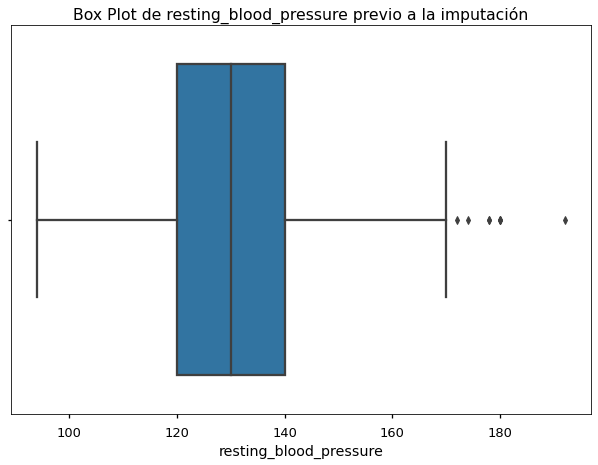

In [89]:
# Reemplazamos el outlier por la mediana
X['resting_blood_pressure'] = X['resting_blood_pressure'].replace(200, np.median(X['resting_blood_pressure']))
sns.boxplot(X['resting_blood_pressure'])
plt.title("Box Plot de resting_blood_pressure previo a la imputación")
plt.show()

<a name="s4"></a>
## Modelos

En la presente sección se armarán distintos modelos en función de lo visto en las cátedras y se evaluarán sus métricas. En primer lugar, se armará el dataset final (feature selection sin los outliers) y se acondicionará el mismo. Asimismo, se construyen dos datasets, uno sin descartar los outliers y otro con el total de las columnas (sin feature selection).

### Datasets Finales

In [90]:
dataset = X[['thalassemia_reversable defect', 'thalassemia_fixed defect', 'st_depression', 'num_major_vessels', 'sex_male', 
             'chest_pain_type_atypical angina', 'exercise_induced_angina_yes', 'max_heart_rate_achieved', 'st_slope_upsloping',
             'st_slope_flat', 'resting_blood_pressure', 'chest_pain_type_typical angina', 'chest_pain_type_non-anginal pain', 'cholesterol']]
dataset.head()

thalassemia_reversable defect  ...  cholesterol
0                              0  ...        233.0
1                              0  ...        250.0
2                              0  ...        204.0
3                              0  ...        236.0
4                              0  ...        354.0

[5 rows x 14 columns]

In [91]:
# Permutamos los índices para hacer el split de 70-20-10 entre el set de training, validation y test
n_samples = dataset.shape[0]
indexes = np.random.permutation(np.arange(0, n_samples))
train_idx = indexes[0:int(0.7*n_samples)]
validation_idx = indexes[int(0.7*n_samples): int(0.9*n_samples)]
test_idx = indexes[int(0.9*n_samples):]
assert n_samples == train_idx.size + validation_idx.size + test_idx.size

x_train = dataset.iloc[train_idx,:]
y_train = y.iloc[train_idx].to_numpy()

x_validation = dataset.iloc[validation_idx,:]
y_validation = y.iloc[validation_idx].to_numpy()

x_test = dataset.iloc[test_idx, :]
y_test = y.iloc[test_idx].to_numpy()

print(x_test.head())
print(x_test.shape)
print(y_test.shape)

     thalassemia_reversable defect  ...  cholesterol
98                               0  ...        315.0
188                              1  ...        233.0
11                               0  ...        275.0
159                              1  ...        221.0
258                              0  ...        244.0

[5 rows x 14 columns]
(31, 14)
(31,)


In [92]:
# normalizar los datos para que vayan entre 0 y 1
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_norm = standard_scaler.fit_transform(x_train)
x_validation_norm = standard_scaler.transform(x_validation)
x_test_norm = standard_scaler.transform(x_test)
print(x_train_norm.min())
print(x_train_norm.max())

-3.444274990484114
3.435327569539048


#### Dataset con Outliers

In [93]:
dataset_outliers = X_outliers[['thalassemia_reversable defect', 'thalassemia_fixed defect', 'st_depression', 'num_major_vessels', 'sex_male', 
             'chest_pain_type_atypical angina', 'exercise_induced_angina_yes', 'max_heart_rate_achieved', 'st_slope_upsloping',
             'st_slope_flat', 'resting_blood_pressure', 'chest_pain_type_typical angina', 'chest_pain_type_non-anginal pain', 'cholesterol']]
             
dataset_outliers.head()

thalassemia_reversable defect  ...  cholesterol
0                              0  ...          233
1                              0  ...          250
2                              0  ...          204
3                              0  ...          236
4                              0  ...          354

[5 rows x 14 columns]

In [94]:
x_train_outliers = dataset_outliers.iloc[train_idx,:]
x_validation_outliers = dataset_outliers.iloc[validation_idx,:]
x_test_outliers = dataset_outliers.iloc[test_idx, :]

print(x_test_outliers.head())
print(x_test_outliers.shape)

     thalassemia_reversable defect  ...  cholesterol
98                               0  ...          315
188                              1  ...          233
11                               0  ...          275
159                              1  ...          221
258                              0  ...          244

[5 rows x 14 columns]
(31, 14)


In [95]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_outliers = standard_scaler.fit_transform(x_train_outliers)
x_validation_outliers = standard_scaler.transform(x_validation_outliers)
x_test_outliers = standard_scaler.transform(x_test_outliers)
print(x_train_outliers.min())
print(x_train_outliers.max())

-3.444274990484114
5.829541007236502


#### Dataset Sin Subsetting

In [96]:
x_train_complete = X.iloc[train_idx,:]
x_validation_complete = X.iloc[validation_idx,:]
x_test_complete = X.iloc[test_idx, :]

print(x_test_complete.head())
print(x_test_complete.shape)

     age  ...  thalassemia_reversable defect
98    43  ...                              0
188   50  ...                              1
11    48  ...                              0
159   56  ...                              1
258   62  ...                              0

[5 rows x 19 columns]
(31, 19)


In [97]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_complete = standard_scaler.fit_transform(x_train_complete)
x_validation_complete = standard_scaler.transform(x_validation_complete)
x_test_complete = standard_scaler.transform(x_test_complete)
print(x_train_complete.min())
print(x_train_complete.max())

-3.444274990484114
7.193747284969078


### Modelo Base
Es un modelo que predice siempre la misma clase para tener un base de rendimiento sobre la que comparar. 

In [98]:
class RandomModel(object):

  def fit(self, X, y):
    return None

  def predict(self, X):
    return np.random.randint(0, 1, size=X.shape[0])

In [99]:
random_model = RandomModel()
random_model.fit(x_train_norm, y_train)
rm_predictions = random_model.predict(x_validation_norm)

In [100]:
fpr, tpr, thresholds = roc_curve(y_validation, rm_predictions)
auc(fpr, tpr)

0.5

### Modelo Base Descriptivo
Al igual que el caso anterior, se desarrolla un modelo base pero ésta vez teniendo en cuenta una de las features que dio mejor resultado en la etapa de feature selection, thalassemia_fixed defect.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


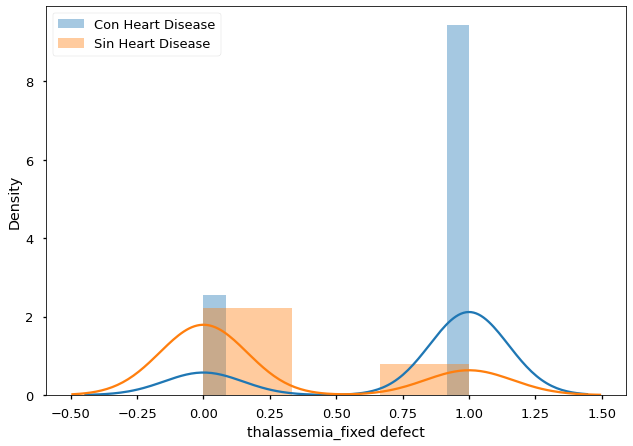

In [101]:
# plot de thalassemia_fixed defect en presencia o no de heart diseases
plt.figure()
sns.distplot(pos['thalassemia_fixed defect'], label = 'Con Heart Disease', kde = True)
sns.distplot(neg['thalassemia_fixed defect'], label = 'Sin Heart Disease', kde = True)
plt.legend()

In [102]:
dataset[dataset['thalassemia_fixed defect'] == 1].index

Int64Index([  1,   2,   3,   4,   6,   9,  10,  11,  12,  13,
            ...
            268, 271, 272, 274, 278, 279, 286, 287, 296, 302],
           dtype='int64', length=165)

En base al plot anterior, se puede armar un modelo donde si thalassemia_fixed defect es igual a 1, se tiene un caso positivo.

In [103]:
class ThalassemiaModel(object):

  def fit(self, X, y):
    return None

  def predict(self, X):
    predictions = np.zeros((X.shape[0]))
    idx = X['thalassemia_fixed defect'] == 1
    idx.to_numpy()
    predictions[idx] = 1
    return predictions

In [104]:
th_model = ThalassemiaModel()
th_model.fit(x_train, y_train)
th_predictions = th_model.predict(x_validation)

In [105]:
fpr, tpr, thresholds = roc_curve(y_validation, th_predictions)
auc(fpr, tpr)

0.8470522803114572

Como se puede observar, el resultado obtenido con este modelo descriptivo es más que aceptable y será un buen benchmark contra el que comparar el resto de los modelos.

### Función para Gráficas

De la documentación de Scikit-Learn [Plotting Learning Curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html), se obtiene una función que calcula y grafica la curva de aprendizaje, la escalabilidad y el rendimiento de un determinado modelo usando validación cruzada.

In [106]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    # axes[2].grid()
    # axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    # axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
    #                      test_scores_mean + test_scores_std, alpha=0.1)
    # axes[2].set_xlabel("fit_times")
    # axes[2].set_ylabel("Score")
    # axes[2].set_title("Performance of the model")

    return plt

### Regresión Logística

In [107]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()
logistic_regression = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]}
lr_model = RandomizedSearchCV(estimator = clf, param_distributions = logistic_regression, n_iter = 20, 
                               cv = 5, verbose= 5, random_state= 101, n_jobs = -1)
lr_model.fit(x_train_norm, y_train)
print(lr_model.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=20. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'C': 0.7}


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished


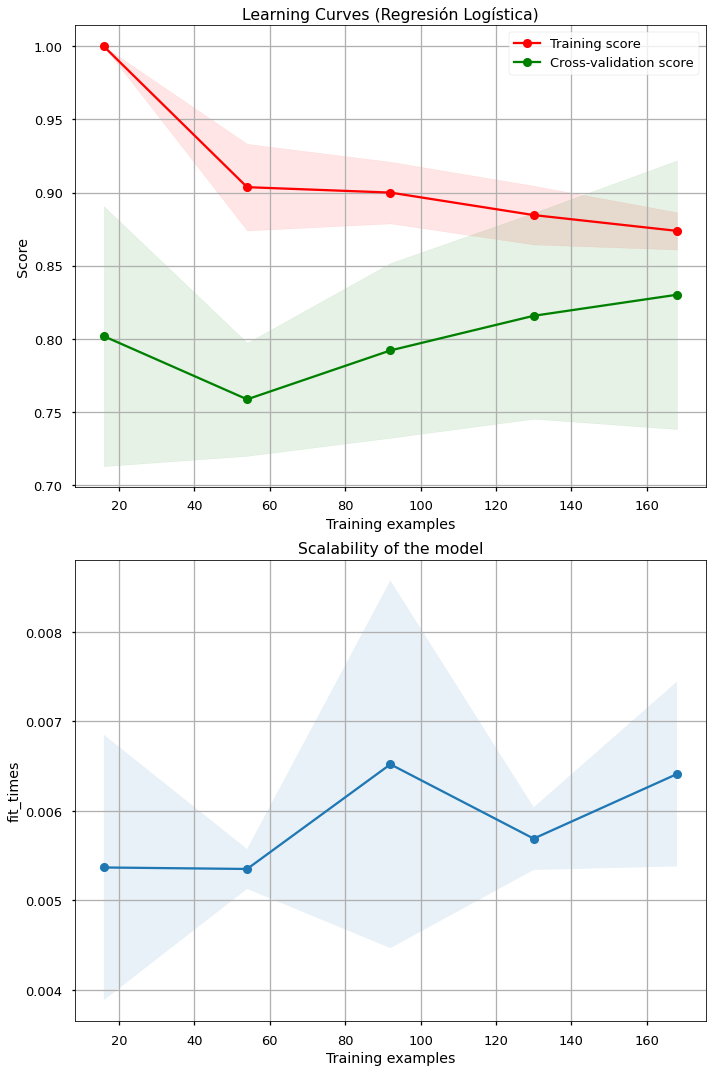

In [108]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

title = "Learning Curves (Regresión Logística)"
estimator = LogisticRegression(C = 0.7)
plot_learning_curve(estimator, title, x_train_norm, y_train, axes=axes)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        29
           1       0.79      0.87      0.83        31

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.82        60
weighted avg       0.82      0.82      0.82        60

Sensitivity :  0.8461538461538461
Specificity :  0.7941176470588235
AUC Regresión Logística:  0.8147942157953282
Recall Logistic Regression:  0.8709677419354839


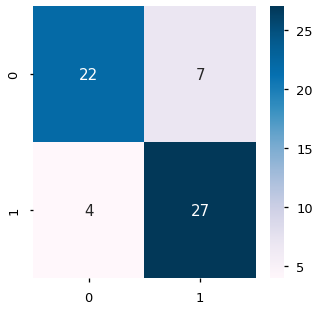

In [109]:
from sklearn.metrics import recall_score

lr_predict = lr_model.best_estimator_.predict(x_validation_norm)
lr_predict_quant = lr_model.best_estimator_.predict_proba(x_validation_norm)

# Confussion Matrix

cm = confusion_matrix(y_validation, lr_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, lr_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, lr_predict)
print('AUC Regresión Logística: ', auc(fpr, tpr))

lr_recall = recall_score(y_validation, lr_predict, average='binary')
print("Recall Logistic Regression: ", lr_recall)

### k-Nearest Neighbors

In [110]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
knn_params = {'n_neighbors' : range(2,50),
              'weights' : ['uniform', 'distance'],
              'metric' : ['euclidian', 'manhattan']}

knn_model = RandomizedSearchCV(estimator = clf, param_distributions = knn_params, n_iter = 20, 
                               cv = 5, verbose= 5, random_state= 101, n_jobs = -1)
knn_model.fit(x_train_norm, y_train)
print(knn_model.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s


{'weights': 'uniform', 'n_neighbors': 37, 'metric': 'manhattan'}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


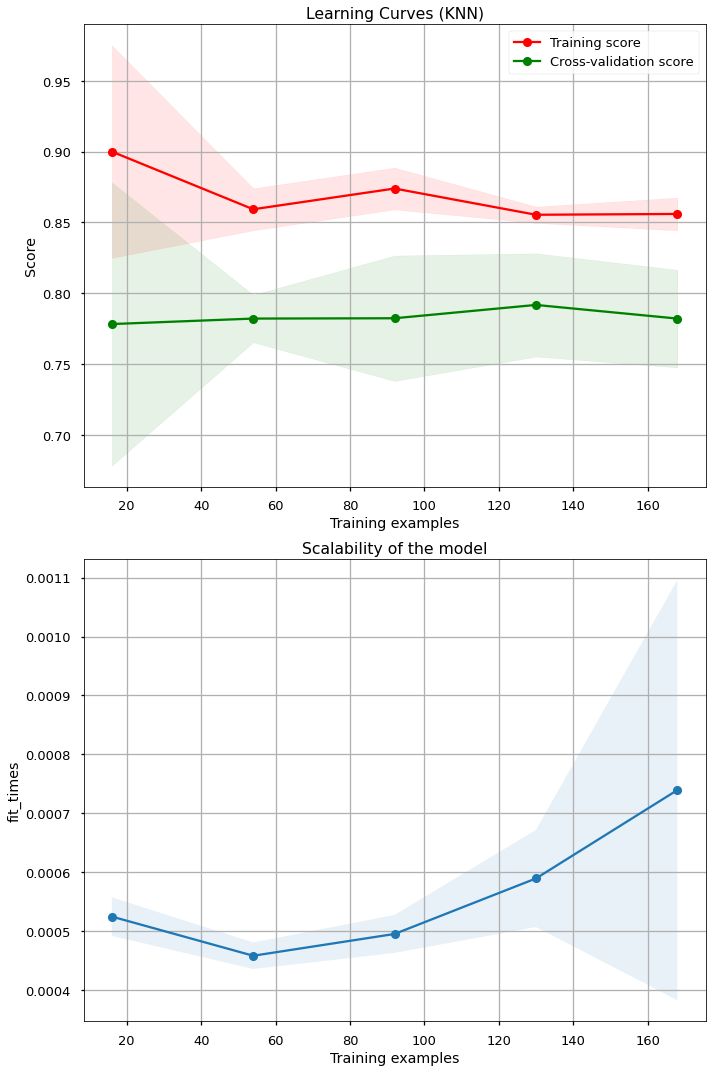

In [111]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

title = "Learning Curves (KNN)"
estimator = KNeighborsClassifier(n_neighbors = 5, metric='manhattan', weights = 'uniform')
plot_learning_curve(estimator, title, x_train_norm, y_train, axes=axes, cv=5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.76      0.83        29
           1       0.81      0.94      0.87        31

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60

Sensitivity :  0.9166666666666666
Specificity :  0.8055555555555556
AUC KNN:  0.8470522803114572
Recall KNN:  0.9354838709677419


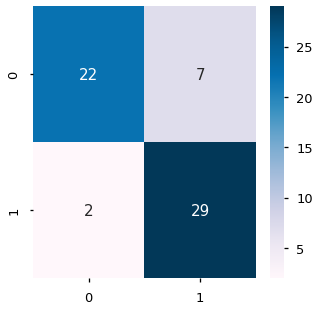

In [112]:
knn_predict = knn_model.best_estimator_.predict(x_validation_norm)
knn_predict_quant = knn_model.best_estimator_.predict_proba(x_validation_norm)

# Confussion Matrix

cm = confusion_matrix(y_validation, knn_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, knn_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, knn_predict)
print('AUC KNN: ', auc(fpr, tpr))

knn_recall = recall_score(y_validation, knn_predict, average='binary')
print("Recall KNN: ", knn_recall)

### Support Vector Machines

In [113]:
clf = SVC()
svc_params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C':[0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.9]}
svm_model = RandomizedSearchCV(estimator = clf, param_distributions = svc_params, n_iter = 20, 
                               cv = 5, verbose= 5, random_state= 101, n_jobs = -1)
svm_model.fit(x_train_norm, y_train)
print(svm_model.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s


{'kernel': 'rbf', 'C': 0.1}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


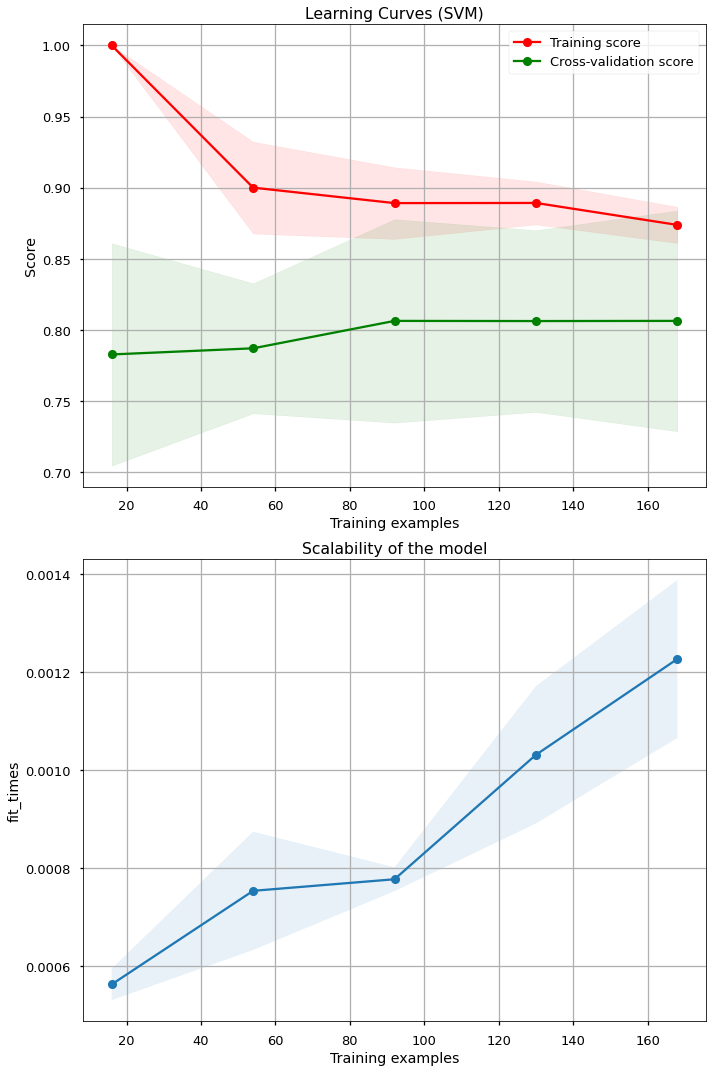

In [114]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

title = "Learning Curves (SVM)"
estimator = SVC(kernel = 'linear', C = 0.2)
plot_learning_curve(estimator, title, x_train_norm, y_train, axes=axes, cv=5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        29
           1       0.78      0.90      0.84        31

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60

Sensitivity :  0.875
Specificity :  0.7777777777777778
AUC SVM:  0.8136818687430479
Recall SVM:  0.9032258064516129


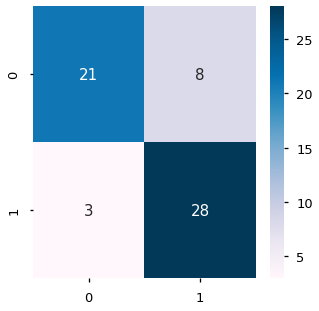

In [115]:
svm_predict = svm_model.best_estimator_.predict(x_validation_norm)

# Confussion Matrix

cm = confusion_matrix(y_validation, svm_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, svm_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, svm_predict)
print('AUC SVM: ', auc(fpr, tpr))

svm_recall = recall_score(y_validation, svm_predict, average='binary')
print("Recall SVM: ", svm_recall)

### Decision Trees

In [116]:
clf = DecisionTreeClassifier()
dtree_params = {'min_samples_leaf': [i for i in range(2,14)]}

dtree_model = RandomizedSearchCV(estimator = clf, param_distributions = dtree_params, n_iter = 20, 
                               cv = 5, verbose= 5, random_state= 101, n_jobs = -1)
dtree_model.fit(x_train, y_train)
print(dtree_model.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'min_samples_leaf': 8}


[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished


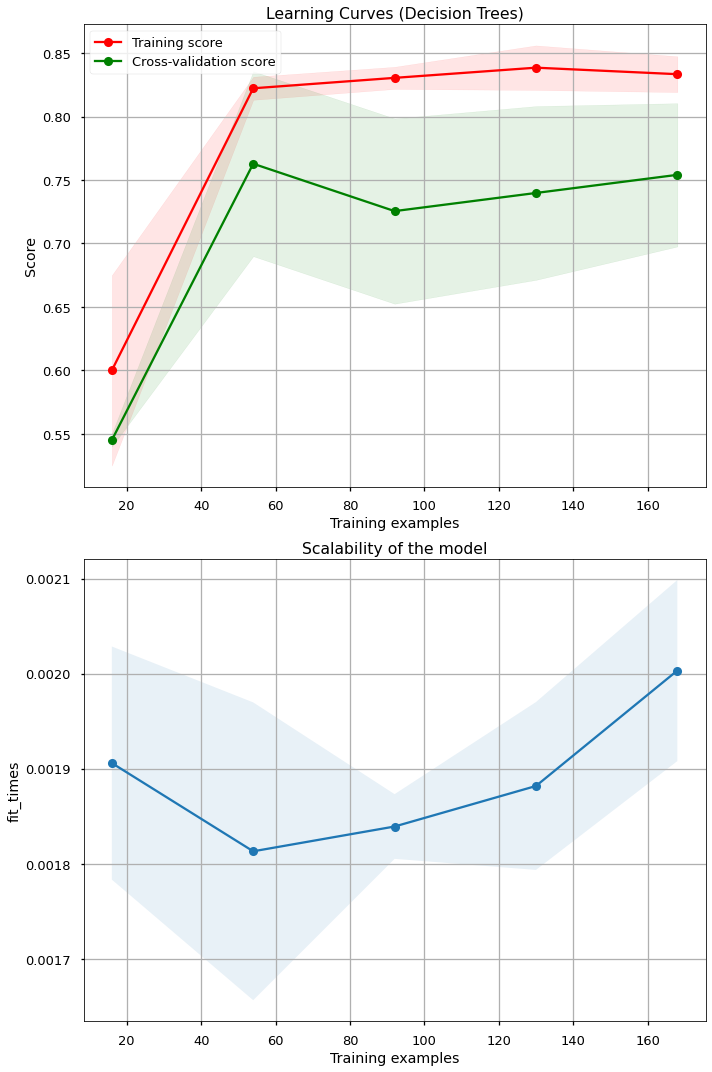

In [117]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

title = "Learning Curves (Decision Trees)"
estimator = DecisionTreeClassifier(min_samples_leaf=11)
plot_learning_curve(estimator, title, x_train, y_train, axes=axes, cv=5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.83      0.81      0.82        31

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60

Sensitivity :  0.8
Specificity :  0.8333333333333334
AUC Decision Trees:  0.8170189098998887
Recall Decision Trees:  0.8064516129032258


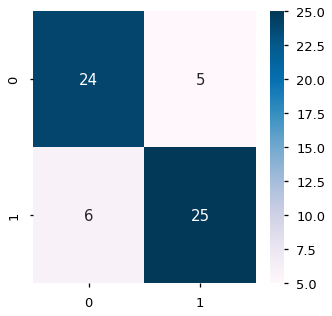

In [118]:
dtree_predict = dtree_model.best_estimator_.predict(x_validation)

# Confussion Matrix

cm = confusion_matrix(y_validation, dtree_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, dtree_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, dtree_predict)
print('AUC Decision Trees: ', auc(fpr, tpr))

dtree_recall = recall_score(y_validation, dtree_predict, average='binary')
print("Recall Decision Trees: ", dtree_recall)

### Random Forest

In [119]:
rf_param = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(2, 10, 1, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16],
               'min_samples_split': [10, 15, 20, 30, 40, 50],
               'n_estimators': list(np.linspace(10, 50, 5, dtype = int))}

clf = RandomForestClassifier()

rf_model = RandomizedSearchCV(estimator = clf, param_distributions = rf_param, n_iter = 100, 
                               cv = 5, verbose= 5, random_state= 101, n_jobs = -1)
rf_model.fit(x_train_norm, y_train)
print(rf_model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   12.4s


{'n_estimators': 20, 'min_samples_split': 30, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'gini'}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.8s finished


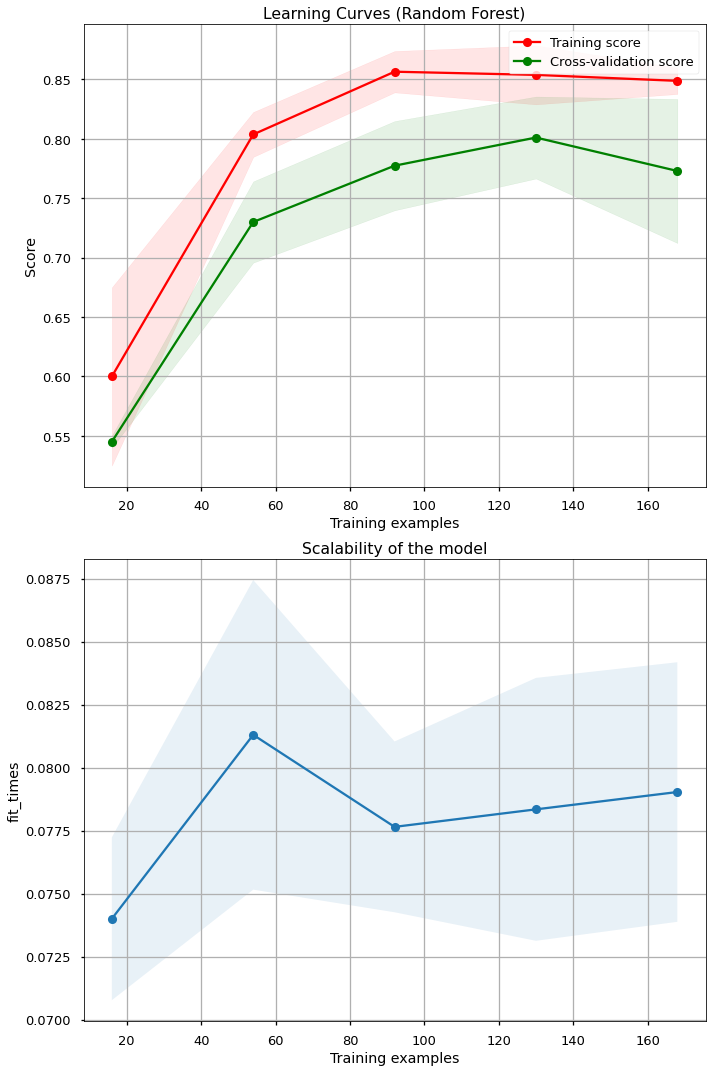

In [120]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

title = "Learning Curves (Random Forest)"
estimator = RandomForestClassifier(min_samples_leaf=14, n_estimators=50, min_samples_split=20, max_features='sqrt', max_depth=None, criterion='gini')
plot_learning_curve(estimator, title, x_train_norm, y_train, axes=axes, cv=5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.69      0.78        29
           1       0.76      0.94      0.84        31

    accuracy                           0.82        60
   macro avg       0.84      0.81      0.81        60
weighted avg       0.83      0.82      0.81        60

Sensitivity :  0.9090909090909091
Specificity :  0.7631578947368421
AUC Random Forest:  0.8125695216907676
Recall Random Forest:  0.9354838709677419


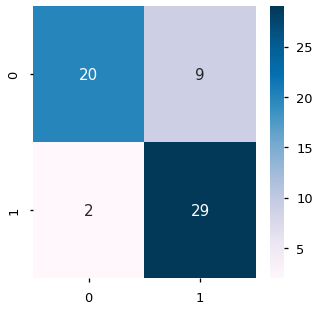

In [121]:
rf_predict = rf_model.best_estimator_.predict(x_validation_norm)

# Confussion Matrix

cm = confusion_matrix(y_validation, rf_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, rf_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, rf_predict)
print('AUC Random Forest: ', auc(fpr, tpr))

rf_recall = recall_score(y_validation, rf_predict, average='binary')
print("Recall Random Forest: ", rf_recall)

Observamos el arbol para explicabilidad del modelo. Se pueden encontrar referencias sobre explicabilidad y específicamente para este dataset en:
*   [Heart Diseases Analysis](https://www.kaggle.com/roshansharma/heart-diseases-analysis/comments)
*   [What causes heart disease - explaining the model](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model)



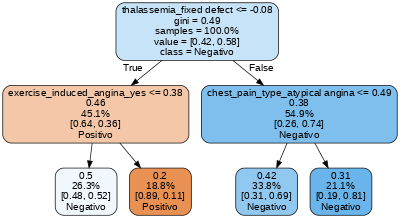

In [122]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call


estimator = rf_model.best_estimator_.estimators_[1]
feature_names = [i for i in x_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'Negativo'
y_train_str[y_train_str == '1'] = 'Positivo'
# y_train_str = y_train_str.values

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=50'])
Image(filename = 'tree.png')



### Adaboost Classifier SKLearn

In [123]:
from sklearn.ensemble import AdaBoostClassifier

ada_param = {'learning_rate': [0.01, 0.05, 0.09, 0.1, 0.15, 0.2]}

clf = AdaBoostClassifier()

ada_model = RandomizedSearchCV(estimator = clf, param_distributions = ada_param, n_iter = 100, 
                               cv = 5, verbose= 5, random_state= 101, n_jobs = -1)
ada_model.fit(x_train, y_train)
print(ada_model.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s


{'learning_rate': 0.2}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.5s finished


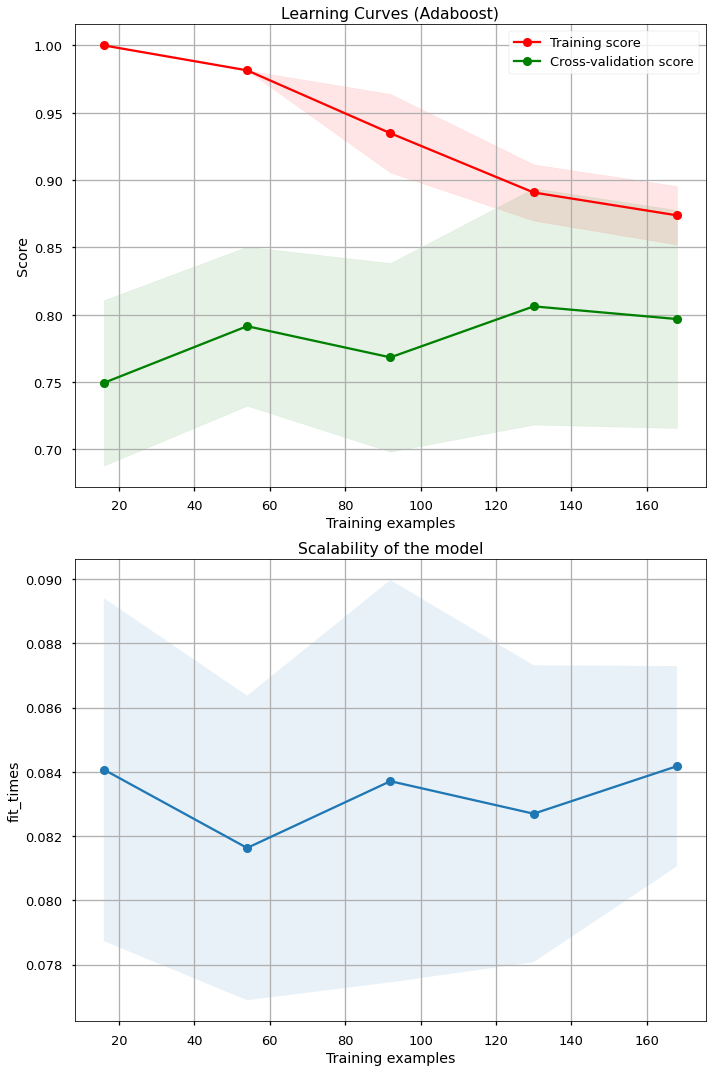

In [124]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

title = "Learning Curves (Adaboost)"
estimator = AdaBoostClassifier(learning_rate=0.15)
plot_learning_curve(estimator, title, x_train, y_train, axes=axes, cv=5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        29
           1       0.78      0.90      0.84        31

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60

Sensitivity :  0.875
Specificity :  0.7777777777777778
AUC Adaboost:  0.8136818687430479
Recall Adaboost:  0.9032258064516129


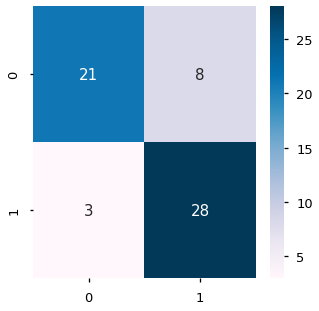

In [125]:
ada_predict = ada_model.best_estimator_.predict(x_validation)

# Confussion Matrix

cm = confusion_matrix(y_validation, ada_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, ada_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, ada_predict)
print('AUC Adaboost: ', auc(fpr, tpr))

ada_recall = recall_score(y_validation, ada_predict, average='binary')
print("Recall Adaboost: ", ada_recall)

### Adaboost Manual

In [126]:
# Adaboost Manual utilizando de ejemplo el Colab visto en clase: https://colab.research.google.com/drive/1F9-PBRAin566eBvwYGdYD9Rc1NJbTEo-#scrollTo=Xc2g-wFPsiMT

class AdaBoost(object):
    
    def __init__(self, base_estimator, n_estimators, learning_rate):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.predictor_weightages = []
        
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):

            # initially all instances have the same weight
            instance_weights = self._initial_instance_weights(n_samples)
            
            # Use predictor to make classification error
            clone_clf = clone(self.base_estimator)
            clone_clf.fit(X, y)
            predicted = clone_clf.predict(X)
            
            # getting misclassified instances
            mis_classified_instances, acc = self._getAccuracy(y, predicted)
            
            # total error made by the predictor
            total_err = self._total_error(mis_classified_instances, instance_weights)
            
            # weightage of predictor based on its error
            predictor_weightage = self._get_predictor_weightage(total_err)
            self.predictor_weightages.append((i, clone_clf, predictor_weightage))
            
            # updating instance weights
            instance_weights = self._update_instance_weights(mis_classified_instances, 
                                                             instance_weights, predictor_weightage)

            
            # sampling data with replacement focusing on instances that were misclassified
            X, y = self._new_sample_set(X, y, instance_weights)

    

    def _initial_instance_weights(self, shape):
        instance_weights = np.full(shape=shape, fill_value=1/shape)
        return instance_weights
    
    
    def _getAccuracy(self, true, predicted):
        assert len(true) == len(predicted)
        error_instance = np.equal(true, predicted).astype(int)
        miss_classified = []

        for i, j in enumerate(error_instance):
            if j == 0:
                miss_classified.append(i)
                
        accuracy = np.sum(true == predicted)
        return miss_classified, (accuracy/len(true)) * 100.0
    
    
    def _total_error(self, mis_classified, instance_weights):
        error = 0
        for i in mis_classified:
            error += instance_weights[i]

        return error
    
    def _get_predictor_weightage(self, error):
        EPS = 1e-5
        weightage = 0.5 * np.log((1.0 - error + EPS) / (error + EPS))
        return weightage

    
    def _update_instance_weights(self, mis_classified_instances, instance_weights, predictor_weightage):
        weights = instance_weights[:]
        EPS = 1e-10
        for idx in range(len(instance_weights)):
            if idx in mis_classified_instances:
                weights[idx] = weights[idx] * np.exp(predictor_weightage + EPS)
            else:
                weights[idx] = weights[idx] * np.exp(-predictor_weightage + EPS)


        # Normalizing weights
        summed_weights = np.sum(weights)
        weights /= summed_weights
        return np.array(weights)
    
    def _new_sample_set(self, X, y, instance_weights):
        intervals = []
        intervals.append(instance_weights[0])

        for i, j in enumerate(instance_weights[1:], 1):
            intervals.append(j + intervals[i-1])

        idxs = []

        for i in range(X.shape[0]):
            samp = np.random.sample()
            try:
                idx = np.searchsorted(intervals, samp, side='right')
                _ = X[idx] # check if exists
            except:
                idx = idx - 1

            finally:
                idxs.append(idx)

        X = X[idxs]
        y = y[idxs]
        return X, y
    
    def predict(self, X):
        clf_predictions = np.array([clf.predict(X) for idx, clf, weightage in self.predictor_weightages])
        predictions = []
        
        for sample_predictions in clf_predictions.T:
            class_0 = 0
            class_1 = 0
            
            for predictor, predictor_op in enumerate(sample_predictions):
                if predictor_op == 0:
                    class_0 += self.predictor_weightages[predictor][2]
                else:
                    class_1 += self.predictor_weightages[predictor][2]
            
            if class_0 > class_1:
                predictions.append(0)
            else:
                predictions.append(1)
        
        return np.array(predictions)

In [128]:
ada_clf = AdaBoost(base_estimator=LogisticRegression(C=0.7),
                  n_estimators=15, learning_rate=0.1)

In [130]:
from sklearn.base import clone

In [132]:
ada_clf.fit(x_train_norm, y_train)
y_ada_pred = ada_clf.predict(x_validation_norm)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        29
           1       0.80      0.77      0.79        31

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60

Sensitivity :  0.7666666666666667
Specificity :  0.8
AUC Adaboost:  0.7836484983314794
Recall Adaboost:  0.7741935483870968


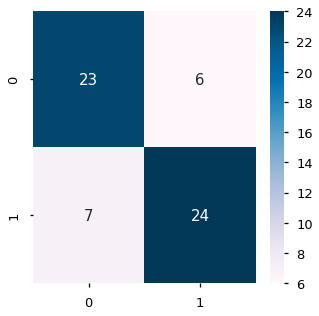

In [133]:
# Confussion Matrix

cm = confusion_matrix(y_validation, y_ada_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, y_ada_pred)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, y_ada_pred)
print('AUC Adaboost: ', auc(fpr, tpr))

ada_recall = recall_score(y_validation, y_ada_pred, average='binary')
print("Recall Adaboost: ", ada_recall)

### Naive Bayes

Se aplica Naive Bayes ya que es un modelo que se utilizó durante el cursado. En éste caso se toma como hipótesis que la distribución subyacente de los datos en Gaussiana, lo cual no pareciera ser el caso. De todos modos, se lo puede utilizar como modelo base. Hay que destacar, que en éste caso las categorías no son fácilmente separables y que no estamos lidiando con un caso de alta dimensionalidad, por lo que no están dadas las condiciones para obtener grandes resultados con éste modelo.

In [185]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(x_train_norm, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

              precision    recall  f1-score   support

           0       0.88      0.79      0.84        29
           1       0.82      0.90      0.86        31

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

Sensitivity :  0.8846153846153846
Specificity :  0.8235294117647058
AUC Naive Bayes:  0.8481646273637375
Recall Naive Bayes:  0.9032258064516129


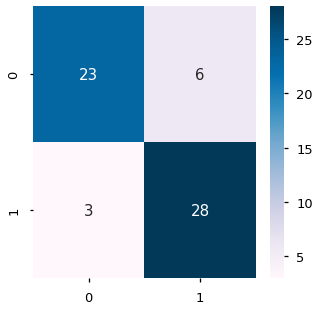

In [186]:
nb_predict = nb_model.predict(x_validation_norm)

# Confussion Matrix

cm = confusion_matrix(y_validation, nb_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, nb_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, nb_predict)
print('AUC Naive Bayes: ', auc(fpr, tpr))

nb_recall = recall_score(y_validation, nb_predict, average='binary')
print("Recall Naive Bayes: ", nb_recall)

### XGBoost Classifier

In [136]:
from xgboost import XGBClassifier

xg_param = {'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90], 
              'learning_rate': [0.05, 0.09, 0.1, 0.15, 0.2],
              'max_depth': [2, 3, 4, 5, 6]}

clf = XGBClassifier(objective='reg:squarederror')

xg_model = RandomizedSearchCV(estimator = clf, param_distributions = xg_param, n_iter = 100, 
                               cv = 5, verbose= 5, random_state= 101, n_jobs = -1)
xg_model.fit(x_train_norm, y_train)
print(xg_model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    4.9s


{'n_estimators': 30, 'max_depth': 2, 'learning_rate': 0.2}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.2s finished


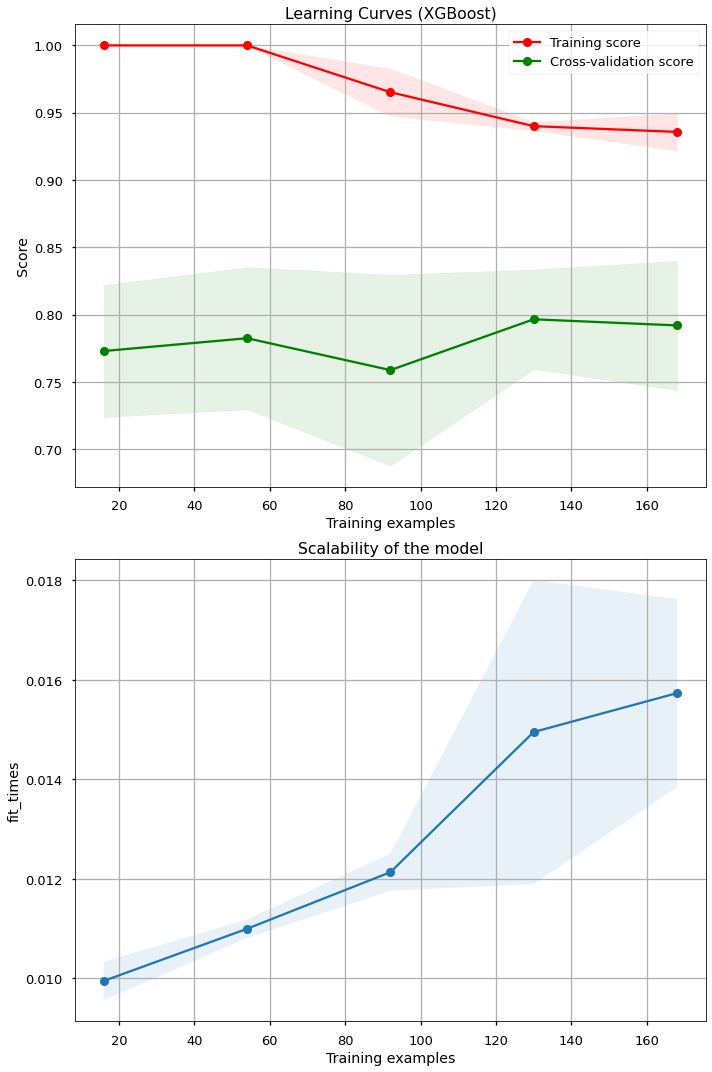

In [137]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

title = "Learning Curves (XGBoost)"
estimator = XGBClassifier(objective='reg:squarederror', n_estimators=70, max_depth=2, learning_rate=0.09)
plot_learning_curve(estimator, title, x_train_norm, y_train, axes=axes, cv=5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.69      0.75        29
           1       0.75      0.87      0.81        31

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60

Sensitivity :  0.8333333333333334
Specificity :  0.75
AUC XGBoost:  0.7803114571746386
Recall XGBoost:  0.8709677419354839


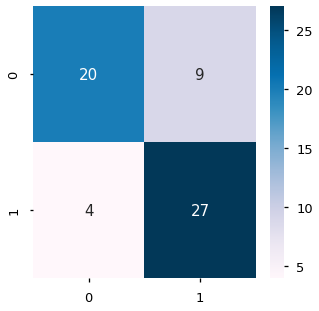

In [138]:
xg_predict = xg_model.best_estimator_.predict(x_validation_norm)

# Confussion Matrix

cm = confusion_matrix(y_validation, xg_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, xg_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, xg_predict)
print('AUC XGBoost: ', auc(fpr, tpr))

xg_recall = recall_score(y_validation, xg_predict, average='binary')
print("Recall XGBoost: ", xg_recall)

### ANN con Keras

In [139]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

In [140]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [141]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Se creará un modelo simple ya que la cantidad de muestras de entrenamiento es limitada y la cantidad de features no es elevada tampoco. Podemos por lo tanto prescindir de varias capas ocultas y de utilizar dropout teniendo en cuenta la cantidad de parámetros a entrenar. 

In [170]:
input_shape = x_train.shape[1]
print(input_shape)

14


In [178]:
from tensorflow.keras import backend as K 

K.clear_session()
del model

In [179]:
model = tf.keras.models.Sequential()

def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(38))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(1))
  model.add(tf.keras.layers.Activation('sigmoid'))
  return model

model = create_model()

metrics = [
    tf.keras.metrics.AUC(),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall")
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=metrics
)


# Se corre el modelo sobre una muestra cualquiera para poder hacer el summary
a = x_train_norm[0, :].reshape(1, -1)
b = model(a)

In [165]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (1, 38)                   570       
_________________________________________________________________
activation (Activation)      (1, 38)                   0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    39        
_________________________________________________________________
activation_1 (Activation)    (1, 1)                    0         
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


En total se tienen 609 parámetros para entrenar lo cual no es demasiado para la cantidad de ejemplos de entrenamiento. Se coloca un callback de EarlyStopping ya que se ha observado durante el entrenamiento que el modelo tiende a caer rápidamente en overfitting. 

In [173]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
)

In [180]:
history=model.fit(
    x_train_norm.astype(np.float32), 
    y_train.astype(np.float32),
    epochs=100,
    batch_size=16,
    # callbacks = [callback],
    validation_data=(x_validation_norm, y_validation),
)

Epoch 1/100
14/14 [==============================] - 3s 80ms/step - loss: 0.7370 - auc: 0.4798 - fn: 82.0000 - fp: 37.0000 - tn: 59.0000 - tp: 33.0000 - precision: 0.4714 - recall: 0.2870 - val_loss: 0.7187 - val_auc: 0.5228 - val_fn: 22.0000 - val_fp: 10.0000 - val_tn: 19.0000 - val_tp: 9.0000 - val_precision: 0.4737 - val_recall: 0.2903
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 0.6261 - auc: 0.7458 - fn: 58.0000 - fp: 20.0000 - tn: 76.0000 - tp: 57.0000 - precision: 0.7403 - recall: 0.4957 - val_loss: 0.6281 - val_auc: 0.7191 - val_fn: 9.0000 - val_fp: 10.0000 - val_tn: 19.0000 - val_tp: 22.0000 - val_precision: 0.6875 - val_recall: 0.7097
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 0.5518 - auc: 0.8565 - fn: 25.0000 - fp: 18.0000 - tn: 78.0000 - tp: 90.0000 - precision: 0.8333 - recall: 0.7826 - val_loss: 0.5631 - val_auc: 0.7920 - val_fn: 6.0000 - val_fp: 8.0000 - val_tn: 21.0000 - val_tp: 25.0000 - val_precision: 0.7576

In [148]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_all(history):
  fig1 = go.Figure()
  fig1.add_trace(go.Scattergl(y=history.history['precision'], name='Train'))
  fig1.add_trace(go.Scattergl(y=history.history['val_precision'], name='Valid'))
  fig1.update_layout(height=300, width=400,xaxis_title='Epoch',yaxis_title='Precision')

  fig2 = go.Figure()
  fig2.add_trace(go.Scattergl(y=history.history['recall'], name='Train'))
  fig2.add_trace(go.Scattergl(y=history.history['val_recall'], name='Valid'))
  fig2.update_layout(height=300, width=400,xaxis_title='Epoch', yaxis_title='Recall')

  fig3 = go.Figure()
  fig3.add_trace(go.Scattergl(y=history.history['loss'], name='Train'))
  fig3.add_trace(go.Scattergl(y=history.history['val_loss'], name='Valid'))
  fig3.update_layout(height=300, width=400,xaxis_title='Epoch', yaxis_title='Loss')

  return [fig1,fig2,fig3]

In [181]:
fig1,fig2,fig3=plot_all(history)
fig1.show()
fig2.show()
fig3.show()

Como se puede observar, gracias a la estrategia de para temprana, se ha logrado evitar el overfitting y buenos resultados en general. Se verifica la cantidad de épocas entrenadas y las métricas.

In [182]:
num_ep = len(history.history['loss'])

In [183]:
print("Cantidad de Epochs antes del Early Stopping: ", num_ep)
print("ANN AUC: ", history.history['val_auc'][num_ep-1])
ann_recall = history.history['val_recall'][num_ep-1]
print("Recall ANN: ", ann_recall)

Cantidad de Epochs antes del Early Stopping:  100
ANN AUC:  0.8743045926094055
Recall ANN:  0.8709677457809448


<a name="s5"></a>

## Comparación de Modelos

En esta sección se compararán todos los modelos implementados y se evaluarán las métricas respecto del dataset de test. Se graficará la curva ROC para todos los métodos.

Se compararán particularmente dos métricas, el AUC y el Recall. La métrica más importante en un problema de detección de enfermedades como este, es el recall ya que es importante que todos los casos que son positivos sean identificados, o lo que es lo mismo, disminuir al máximo los falsos negativos.

In [184]:
from sklearn.metrics import accuracy_score

In [188]:
models = {'Base': random_model, 'Thalassemia Model': th_model, 'Regresión Logístic': lr_model.best_estimator_,
          'k-Nearest Neighbors': knn_model.best_estimator_, 'Support Vector Machines': svm_model.best_estimator_, 
          'Decision Trees': dtree_model.best_estimator_, 'Random Forest': rf_model.best_estimator_, 
          'Adaboost': ada_model.best_estimator_, 'Adaboost Manual':ada_clf,'Naive Bayes':nb_model,'XGBoost': xg_model.best_estimator_, 'ANN': model}
recalls = {}
accuracies = {}
auc_test = {}
fpr_test = {}
tpr_test = {}

keys = list(models.keys())

for i, mdl in enumerate(models.values()):
  if keys[i] == 'Thalassemia Model':
    df_test = pd.DataFrame(x_validation, columns = dataset.columns)
    y_pred = mdl.predict(df_test)
  elif keys[i] == 'ANN':
    y_pred = mdl.predict(x_validation_norm)
    y_pred = np.argmax(y_pred, axis=1)
  elif (keys[i] == 'Adaboost') | (keys[i] == 'Decision Trees'):
    y_pred = mdl.predict(x_validation)
  else:  
    y_pred = mdl.predict(x_validation_norm)
  accuracies[keys[i]] = accuracy_score(y_validation, y_pred)
  recalls[keys[i]] = recall_score(y_validation, y_pred)
  fpr, tpr, th = roc_curve(y_validation, y_pred)
  auc_test[keys[i]] = auc(fpr, tpr)
  fpr_test[keys[i]] = fpr
  tpr_test[keys[i]] = tpr

In [189]:
print("Accuracy de los modelos: ", accuracies)
print("Recall de los modelos: ", recalls)

Accuracy de los modelos:  {'Base': 0.48333333333333334, 'Thalassemia Model': 0.85, 'Regresión Logístic': 0.8166666666666667, 'k-Nearest Neighbors': 0.85, 'Support Vector Machines': 0.8166666666666667, 'Decision Trees': 0.8166666666666667, 'Random Forest': 0.8166666666666667, 'Adaboost': 0.8166666666666667, 'Adaboost Manual': 0.7833333333333333, 'Naive Bayes': 0.85, 'XGBoost': 0.7833333333333333, 'ANN': 0.48333333333333334}
Recall de los modelos:  {'Base': 0.0, 'Thalassemia Model': 0.9354838709677419, 'Regresión Logístic': 0.8709677419354839, 'k-Nearest Neighbors': 0.9354838709677419, 'Support Vector Machines': 0.9032258064516129, 'Decision Trees': 0.8064516129032258, 'Random Forest': 0.9354838709677419, 'Adaboost': 0.9032258064516129, 'Adaboost Manual': 0.7741935483870968, 'Naive Bayes': 0.9032258064516129, 'XGBoost': 0.8709677419354839, 'ANN': 0.0}


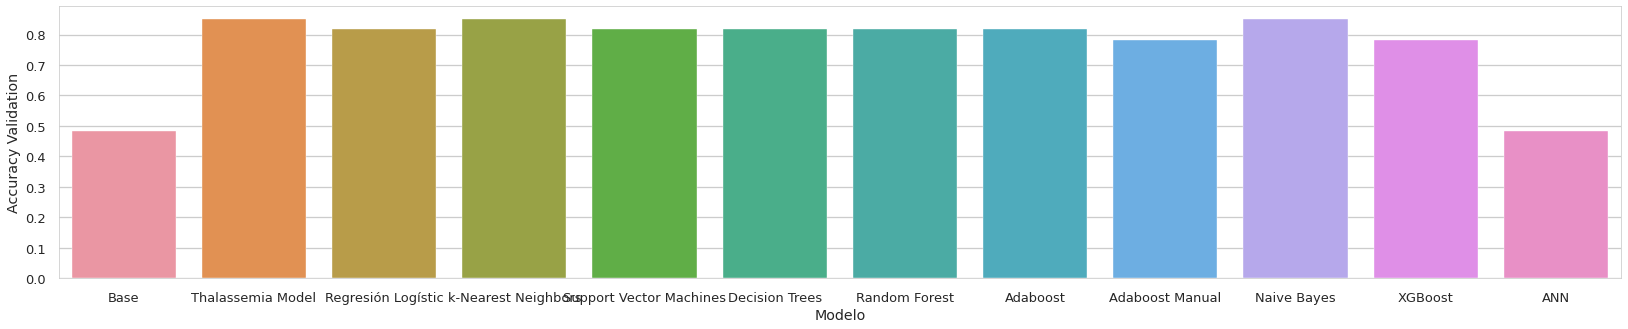

In [190]:
sns.set_style("whitegrid")
plt.figure(figsize = (28, 5))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel("Accuracy Validation")
plt.xlabel("Modelo")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

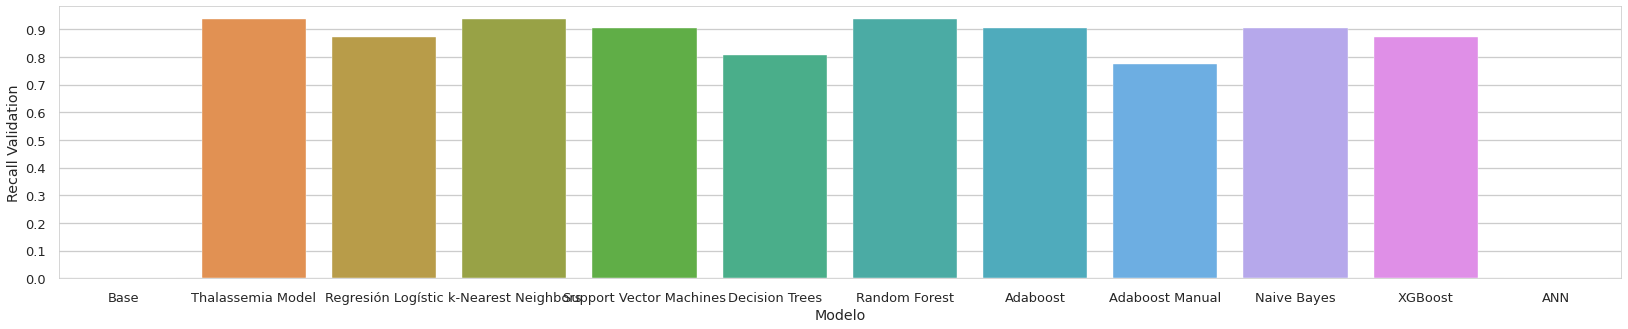

In [191]:
sns.set_style("whitegrid")
plt.figure(figsize = (28, 5))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel("Recall Validation")
plt.xlabel("Modelo")
sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
plt.show()

In [192]:
recalls_test = {}
accuracies_test = {}


for i, mdl in enumerate(models.values()):
  if keys[i] == 'Thalassemia Model':
    df_test = pd.DataFrame(x_test, columns = dataset.columns)
    y_pred = mdl.predict(df_test)
  elif keys[i] == 'ANN':
    y_pred = mdl.predict(x_test_norm)
    y_pred = np.argmax(y_pred, axis=1)
  elif (keys[i] == 'Adaboost') | (keys[i] == 'Decision Trees'):
    y_pred = mdl.predict(x_test)
  else:  
    y_pred = mdl.predict(x_test_norm)
  accuracies_test[keys[i]] = accuracy_score(y_test, y_pred)
  recalls_test[keys[i]] = recall_score(y_test, y_pred)
  fpr, tpr, th = roc_curve(y_test, y_pred)
  auc_test[keys[i]] = auc(fpr, tpr)
  fpr_test[keys[i]] = fpr
  tpr_test[keys[i]] = tpr

In [193]:
print("Accuracy de los modelos - test: ", accuracies_test)
print("Recall de los modelos - test: ", recalls_test)

Accuracy de los modelos - test:  {'Base': 0.41935483870967744, 'Thalassemia Model': 0.7741935483870968, 'Regresión Logístic': 0.9354838709677419, 'k-Nearest Neighbors': 0.8387096774193549, 'Support Vector Machines': 0.8709677419354839, 'Decision Trees': 0.7096774193548387, 'Random Forest': 0.8387096774193549, 'Adaboost': 0.7741935483870968, 'Adaboost Manual': 0.9032258064516129, 'Naive Bayes': 0.9032258064516129, 'XGBoost': 0.8387096774193549, 'ANN': 0.41935483870967744}
Recall de los modelos - test:  {'Base': 0.0, 'Thalassemia Model': 0.7222222222222222, 'Regresión Logístic': 0.8888888888888888, 'k-Nearest Neighbors': 0.8333333333333334, 'Support Vector Machines': 0.8888888888888888, 'Decision Trees': 0.6111111111111112, 'Random Forest': 0.8333333333333334, 'Adaboost': 0.7777777777777778, 'Adaboost Manual': 0.8333333333333334, 'Naive Bayes': 0.8888888888888888, 'XGBoost': 0.8333333333333334, 'ANN': 0.0}


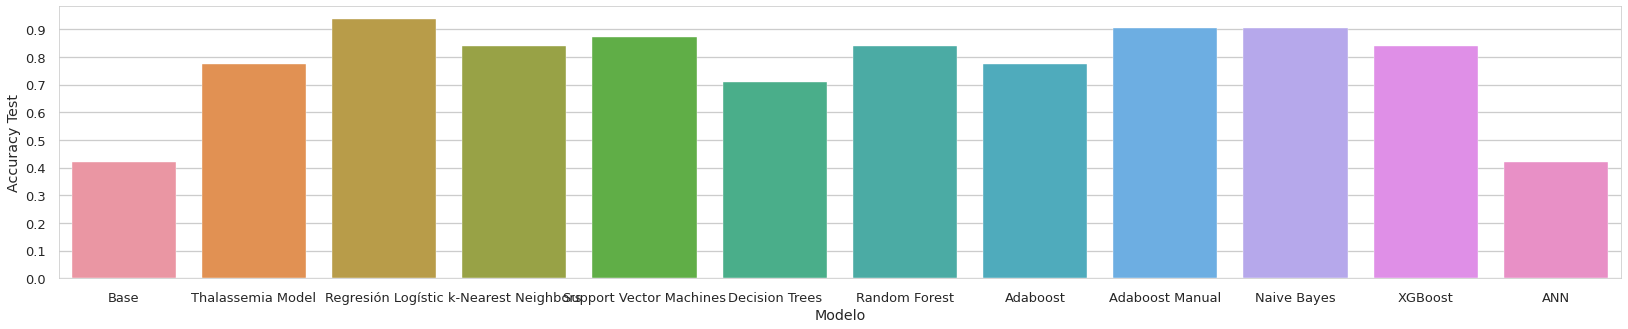

In [194]:
sns.set_style("whitegrid")
plt.figure(figsize = (28, 5))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel("Accuracy Test")
plt.xlabel("Modelo")
sns.barplot(x=list(accuracies_test.keys()), y=list(accuracies_test.values()))
plt.show()

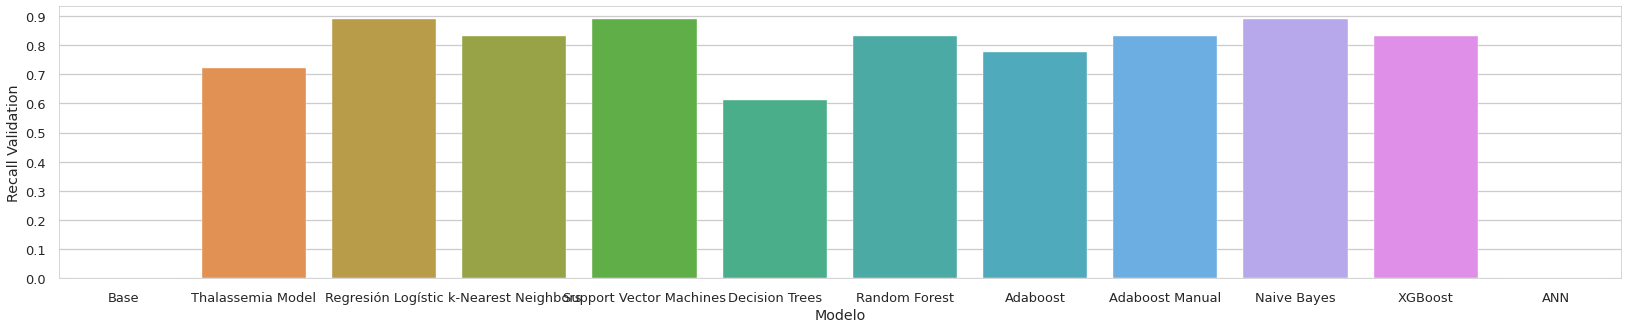

In [195]:
sns.set_style("whitegrid")
plt.figure(figsize = (28, 5))
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel("Recall Validation")
plt.xlabel("Modelo")
sns.barplot(x=list(recalls_test.keys()), y=list(recalls_test.values()))
plt.show()

### Curva ROC

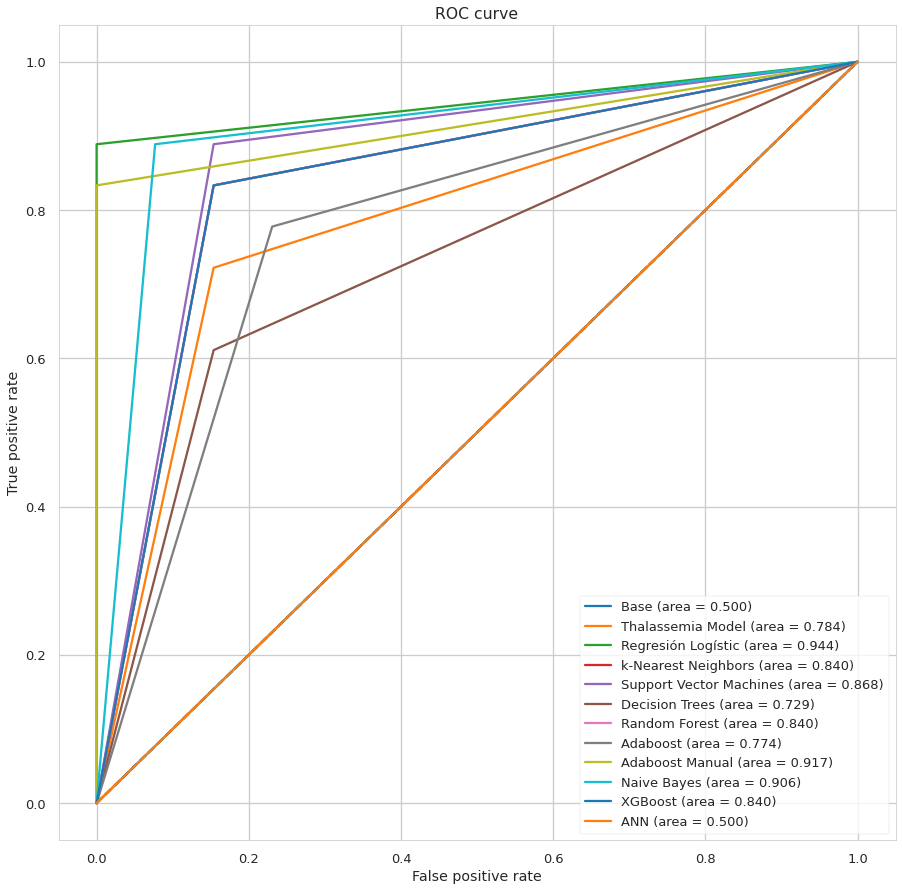

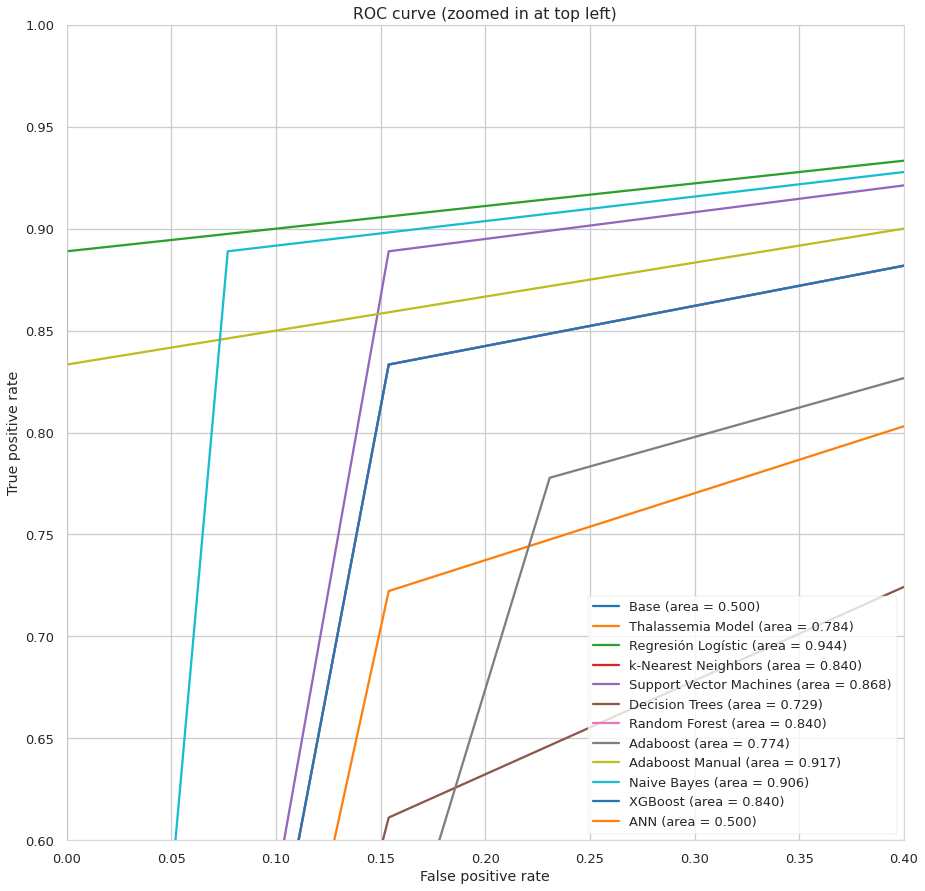

In [196]:
plt.figure(1, figsize=(15, 15))
plt.plot([0, 1], [0, 1], 'k--')
for i, mdl in enumerate(models.values()):
  plt.plot(fpr_test[keys[i]], tpr_test[keys[i]], label='{} (area = {:.3f})'.format(keys[i], auc_test[keys[i]]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2, figsize=(15, 15))
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
for i, mdl in enumerate(models.values()):
  plt.plot(fpr_test[keys[i]], tpr_test[keys[i]], label='{} (area = {:.3f})'.format(keys[i], auc_test[keys[i]]))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### Ajuste Hiperparámetros - Regresión Logística

#### Randomized Search

In [197]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
import time

In [218]:
parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': loguniform(1e-5, 100),
    'class_weight': ['balanced', None]
}

In [219]:
start_time = time.time()
clf_random = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=parameters, n_iter=100, random_state=0, n_jobs=-1, scoring=['accuracy'], refit='accuracy')
clf_random.fit(x_train_norm, y_train)
print("seconds: ", (time.time() - start_time))
clf_random.best_estimator_

seconds:  2.8155956268310547


LogisticRegression(C=0.762081487759898, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [220]:
clf_random.best_score_

0.8301218161683279

#### Grid Search Fino

In [206]:
from sklearn.model_selection import GridSearchCV

In [221]:
reduce_parameters = {
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'C': [1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1, 1],
    'class_weight': [None]
}

In [222]:
start_time = time.time()
clf_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=reduce_parameters, n_jobs=-1, scoring=['accuracy'], refit='accuracy')
clf_grid.fit(x_train_norm, y_train)
print("seconds:", (time.time() - start_time))
clf_grid.best_estimator_

seconds: 0.15020012855529785


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [223]:
clf_grid.best_score_

0.8348837209302327

### Regresión Logística sobre Dataset con Anomalías y Dataset Completo

#### Dataset con Anomalías

In [224]:
lr_model = LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

lr_model.fit(x_train_outliers, y_train)

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        29
           1       0.79      0.87      0.83        31

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.82        60
weighted avg       0.82      0.82      0.82        60

Sensitivity :  0.8461538461538461
Specificity :  0.7941176470588235
AUC Regresión Logística:  0.8147942157953282
Recall Logistic Regression:  0.8709677419354839


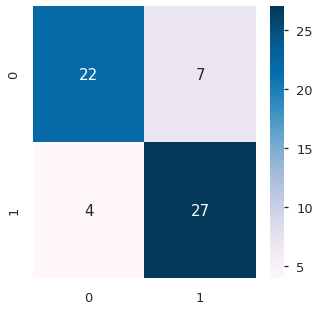

In [225]:

lr_predict = lr_model.predict(x_validation_outliers)
lr_predict_quant = lr_model.predict_proba(x_validation_outliers)

# Confussion Matrix

cm = confusion_matrix(y_validation, lr_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, lr_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, lr_predict)
print('AUC Regresión Logística: ', auc(fpr, tpr))

lr_recall = recall_score(y_validation, lr_predict, average='binary')
print("Recall Logistic Regression: ", lr_recall)

#### Dataset Completo

In [226]:
lr_model = LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

lr_model.fit(x_train_complete, y_train)

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.88      0.76      0.81        29
           1       0.80      0.90      0.85        31

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60

Sensitivity :  0.88
Specificity :  0.8
AUC Regresión Logística:  0.8309232480533927
Recall Logistic Regression:  0.9032258064516129


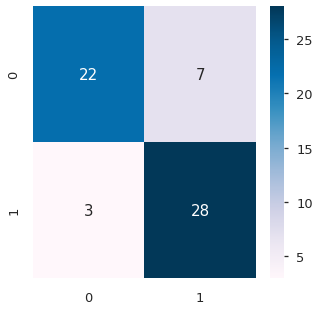

In [227]:
lr_predict = lr_model.predict(x_validation_complete)
lr_predict_quant = lr_model.predict_proba(x_validation_complete)

# Confussion Matrix

cm = confusion_matrix(y_validation, lr_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_validation, lr_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_validation, lr_predict)
print('AUC Regresión Logística: ', auc(fpr, tpr))

lr_recall = recall_score(y_validation, lr_predict, average='binary')
print("Recall Logistic Regression: ", lr_recall)

### Conclusión

Como se puede observar de la curva ROC, todos los modelos se han desempeñado con rendimientos similares. Algunas consideraciones:

* Es llamativo las buenas métricas que el modelo base descriptivo tiene, siendo que se basa en una sola feature.
* Si nos centramos únicamente en el problema, se debería implementar en producción el modelo que mejor recall tiene tanto en el set de validación como el de test, que en este caso son la regresión logística, SVM y Naive Bayes. Modificando los hiperparámetros de la regresión logística y experimentando con los otros datasets, se obtuve grandes resultados usando el dataset completo. 
* La red neuronal implementada no tiene muy buenas métricas, se podría probar modificando los hiperparámetros, agregando las features descartadas o directamente con otro tipo de arquitectura.
* Existen algunas diferencias entre el desempeño de varios de los modelos en el set de validación respecto del de test.




### Trabajo Futuro

Se deja para trabajo futuro los siguiente puntos:

* Modificar los hiperparámetros de la red neuronal para obtener mejores métricas.
* Analizar la explicabilidad de los modelos (shap values, lime, eli5, etc.)
* Realizar el deployment del modelo. 